## Pre/Post resection analysis for Olink

In [ ]:
# https://docs.google.com/document/d/1u_GP7pk8l0AXfM9Ligeycq3wx9phAHSZpM93wM-mNTs/edit

## Issues with the paired data set

# Unknown values exist for analysis batch and tissue disposition.
# Some samples are cancer_type Unclassifiable
# Some samples are tissue_status 'Biopsied'

# some samples have different cancer_type between pre and post resection samples
# some samples have different path_type between pre and post resection (path_type needed to determine which samples are 'neg by histology')

# going to have to assume here that pre/post samples were processed in the same tube type, EDTA for DC1 and LBG for DC2
# there is one tissue disposition value in LIMS per patient

In [4]:
import pandas as pd
import numpy as np
from collections import Counter

import scipy.stats

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
from pineapple.contrib.components.transformers.common.combat_transformer import CombatTransformer

pd.set_option('display.max_rows', 500)

import statsmodels.api as sm

import seaborn as sns

from statsmodels.stats.multitest import multipletests
from scipy import stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#from matplotlib_venn import venn3
from venn import venn

ModuleNotFoundError: No module named 'venn'

In [5]:
%load_ext autoreload
%autoreload 2


In [3]:
#import cancer_type 'imputed' data table
df_olink_paired = pd.read_csv(open("./df_paired_olinks_pathol_corrected.csv","r"))
df_olink_paired = df_olink_paired.fillna("unknown")
#df_olink_paired
df_olink_paired.head()

,assay,lims_batch,sample_id,patient_id,blood_draw_relative_to_tx,cancer_type,Study,Analysis_Batch,passed_latest_qc,tissue_disposition,olink_dsid,path_type,path_sub_type
0,targeted-panel,DC2_BG1_Olink_1,22808,24564,Post-Colonoscopy,Colorectal Pre-Cancer,DC2 BG1,unknown,True,Completely Resected,SD-000092B8,AA,AA2.2
1,targeted-panel,DC2_BG1_Olink_1,23394,25603,Post-Colonoscopy,Colorectal Normal / Healthy,DC2 BG1,unknown,True,unknown,SD-000092E1,Negative by histopathology,unknown
2,targeted-panel,DC2_BG1_Olink_1,21163,24435,Post-Colonoscopy,Colorectal Pre-Cancer,DC2 BG1,unknown,True,Completely Resected,SD-000092A4,AA,AA2.3
3,targeted-panel,DC2_BG1_Olink_1,20983,24445,Post-Colonoscopy,Colorectal Normal / Healthy,DC2 BG1,unknown,True,Biopsied,SD-000092C4,Negative by histopathology,unknown
4,targeted-panel,DC2_BG1_Olink_1,21655,24705,Post-Colonoscopy,Colorectal Normal / Healthy,DC2 BG1,unknown,True,Completely Resected,SD-000092B7,Negative by histopathology,unknown


In [4]:
#df_olink_paired = df_olink_paired.fillna("unknown")
#df_olink_paired.groupby(["patient_id","Analysis_Batch","blood_draw_relative_to_tx"])[["sample_id"]].count()

# the question is here, whether samples with 'unknown analysis batch' were LBG or EDTA tubes . 

set(df_olink_paired["path_type"])

{'AA',
 'NAA',
 'Negative by colonoscopy (no histopathology)',
 'Negative by histopathology',
 'unknown'}

In [5]:
# retrieve more tissue resection status info from Calzone
from calzone import Calzone, CalzoneSampleMetadata

In [6]:
# an alternative place to get tissue disposition
'''
dsids = df_olink_paired.loc[df_olink_paired["blood_draw_relative_to_tx"]=="Post-Colonoscopy", "olink_dsid"]
print(len(dsids))

metadata = Calzone.get_dataset_metadata_with_ids(
    dsids,
    load_options=[CalzoneSampleMetadata])
'''

'\ndsids = df_olink_paired.loc[df_olink_paired["blood_draw_relative_to_tx"]=="Post-Colonoscopy", "olink_dsid"]\nprint(len(dsids))\n\nmetadata = Calzone.get_dataset_metadata_with_ids(\n    dsids,\n    load_options=[CalzoneSampleMetadata])\n'

In [80]:
# an alternative place to get tissue disposition
'''
#data = [d.raw_sample_metadata['lims_hd_colonoscopy_findings_v2'][0]['tissue_disposition'] for d in metadata]

sid_to_dispo2 = {}
for i, d in enumerate(metadata):
    sid = d.raw_dataset_metadata['dataset']['sample_id']
    pid = d.raw_sample_metadata['lims_patient']['id']
    try:
        sid_to_dispo2[sid] = (d.raw_sample_metadata['lims_hd_colonoscopy_findings_v2'][0]['tissue_disposition'])
    except:
        sid_to_dispo2[sid] = "NA"  # these are all Neg by colonoscopy and one Unclassifiable sample
        #print(d.raw_sample_metadata['lims_patient']['id'])
        #print(d.raw_sample_metadata['lims_top_diagnosis']['pathologic_type'])
    
    
#data = [d.raw_sample_metadata['lims_hd_colonoscopy_findings_v2'][0]['tissue_disposition'] for d in metadata[0]]
Counter(sid_to_dispo2.values())
'''
# these data all pretty much match existing tissue dispo infomration

Counter({'Completely Resected': 81,
         'Biopsied': 3,
         'NA': 41,
         'Irrecuperable after resection': 1})

In [5]:
df_olink_paired.groupby(["Analysis_Batch"])[["sample_id"]].count()

,sample_id
Analysis_Batch,
DC1,17
PON,13
alpha,26
beta,26
delta,31
gamma,26
unknown,113


In [6]:
# set impute tube type as whatever the pre-sample batch was, unless it was unknown. 
pid_to_tube = {}
for pid, df in df_olink_paired.groupby(["patient_id"]):
    batch = df.loc[df["blood_draw_relative_to_tx"]=="Pre-Colonoscopy", "Analysis_Batch"].values
    tube = None
    if batch == "DC1" or batch == "PON": 
        tube = "EDTA"
    elif batch in ["alpha","beta","delta","gamma"]:
        tube = "LBG"
    elif batch == "unknown":
        batch_post == df.loc[df["blood_draw_relative_to_tx"]=="Post-Colonoscopy", "Analysis_Batch"].values
        if batch_post == "DC1" or batch == "PON": 
            tube = "EDTA"
        elif batch_post in ["alpha","beta","delta","gamma"]:
            tube = "LBG"
        elif batch_post == "unknown":
            print(f"unknown tube type/batches {pid}")
            break
    pid_to_tube[pid] = tube

print(len(pid_to_tube.keys()))
print(Counter(pid_to_tube.values()))

df_olink_paired["tube_type"] = [pid_to_tube[pid] for pid in df_olink_paired["patient_id"]]

126
Counter({'LBG': 109, 'EDTA': 17})


In [8]:
# remove unknown disease type (8 samples, 4 patients)
df_olink_paired = df_olink_paired[df_olink_paired["cancer_type"]!="Unclassifiable"]
df_olink_paired.shape


(244, 14)

In [9]:
# remove biopsied samples
print(Counter(df_olink_paired["tissue_disposition"]))
#pid_remov = df_olink_paired.loc[df_olink_paired["tissue_disposition"]=="Biopsied","patient_id"].values
pid_remov = df_olink_paired.loc[df_olink_paired["tissue_disposition"]=="Biopsied","patient_id"].values
df_olink_paired = df_olink_paired[~df_olink_paired["patient_id"].isin(list(set(pid_remov)))]

print(df_olink_paired.shape)
Counter(df_olink_paired["tissue_disposition"])

Counter({'pre-colo': 122, 'unknown': 62, 'Completely Resected': 57, 'Biopsied': 3})
(238, 14)


Counter({'Completely Resected': 57, 'unknown': 62, 'pre-colo': 119})

In [10]:
df_olink_paired.groupby(["blood_draw_relative_to_tx","Analysis_Batch"])[["sample_id"]].count()

sample_id
blood_draw_relative_to_tx Analysis_Batch           
Post-Colonoscopy          PON                    13
                          unknown               106
Pre-Colonoscopy           DC1                    16
                          alpha                  24
                          beta                   24
                          delta                  31
                          gamma                  24

In [102]:
# import data (run twice)
dsids = df_olink_paired["olink_dsid"].values

mat_all = mf.create_from_dataset_ids(dataset_ids=dsids, feature_str="olink_all_panels_disc2/v1",
                                    dataset_labels=labels,
                                    ) # read in as pairs!!
mat_all.shape
print(mat_all.sample_ids[0:15])

dsid_to_ctype = {}
for i,d in enumerate(mat_all.sample_metadata):
    dsid = mat_all.dataset_ids[i]
    ctype = d.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"]
    dsid_to_ctype[dsid]=ctype

labels = [dsid_to_ctype[dsid] for dsid in dsids]
#new_labels = [1 if lb=="Colorectal Cancer" else 0 for lb in labels]
Counter(mat_all.y)
# an AA sid: 19733

[18302 18309 18389 18431 18937 19053 19222 19347 19351 19460 19723 19728
 19733 19744 19747]


Counter({'Colorectal Normal / Healthy': 101,
         'Colorectal Benign': 68,
         'Colorectal Pre-Cancer': 66,
         'Unclassifiable': 3})

In [13]:
## check that the labeling worked above!!!
#a = [1,1,1]
#b = [1,1,1]
a=mat_all.y
b=[ d.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"] for d in mat_all.sample_metadata]
#b = [1 if lb=="Colorectal Cancer" else 0 for lb in b]
print(a[0:10])
print(b[0:10])

assert all([a==b for a,b in zip(a,b )])


['Colorectal Normal / Healthy' 'Colorectal Benign'
 'Colorectal Normal / Healthy' 'Colorectal Normal / Healthy'
 'Colorectal Normal / Healthy' 'Colorectal Normal / Healthy'
 'Colorectal Normal / Healthy' 'Colorectal Benign'
 'Colorectal Normal / Healthy' 'Colorectal Normal / Healthy']
['Colorectal Normal / Healthy', 'Colorectal Benign', 'Colorectal Normal / Healthy', 'Colorectal Normal / Healthy', 'Colorectal Normal / Healthy', 'Colorectal Normal / Healthy', 'Colorectal Normal / Healthy', 'Colorectal Benign', 'Colorectal Normal / Healthy', 'Colorectal Normal / Healthy']


In [14]:
# add tube type to the metadata
for d in mat_all.dataset_metadata:
    pid = d.raw_sample_metadata['lims_patient']["id"]
    d.raw_dataset_metadata['dataset']['collection_tube_type'] = pid_to_tube[pid]

Counter([d.raw_dataset_metadata['dataset']['collection_tube_type'] for d in mat_all.dataset_metadata])


Counter({'EDTA': 32, 'LBG': 206})

In [15]:
def impute_as_mean(matrix, matrix_for_means):
    ''' the two input matrixes have to have the same number of cols'''
    means = np.nanmedian(matrix_for_means.x, axis=0)
    inds = np.where(np.isnan(matrix.x))
    replace = np.array(matrix.x) 
    # for the indices with nans, replace with the column mean
    replace[inds] = np.take(means, inds[1])
    #print(np.isnan(replace).sum())
    matrix = matrix.replace_x(x=replace)
    assert np.isnan(matrix.x).sum().sum()==0

    return matrix

In [16]:
mat_all = impute_as_mean(mat_all,mat_all)

In [17]:
# set all prot values below LOD to 0
lods = [d["LOD"] for d in mat_all.column_metadata]
df = pd.DataFrame(mat_all.x)
df = df.mask(df<lods, 0)
mat_all = mat_all.replace_x(x=np.array(df))
pd.DataFrame(mat_all.x).head()

,0,1,2,3,4,5,6,7,8,9,...,910,911,912,913,914,915,916,917,918,919
0,1.41114,4.41676,6.73035,4.37132,8.83530,2.55360,2.85157,4.93952,4.14895,7.57457,...,0.0,1.54460,2.14102,4.08415,5.35640,2.10225,3.38681,4.33060,0.00000,0.0000
1,1.76991,6.45935,6.53514,4.05910,9.41657,2.55037,2.69801,5.65088,3.97700,7.30807,...,0.0,1.69212,2.33684,4.44854,5.95481,2.05533,2.33025,2.31211,0.00000,1.3615
2,1.46652,6.11195,6.61230,4.42857,8.61249,2.20633,2.37498,5.33980,4.63120,7.44287,...,0.0,1.61916,2.62118,4.27708,5.57113,1.57784,3.59760,3.32692,0.00000,0.0000
3,1.93160,6.07420,6.36216,4.04096,8.90259,2.53733,2.32774,5.08178,3.85081,7.17803,...,0.0,1.45088,2.23041,4.46821,5.73260,2.14375,4.19102,1.44244,1.76888,0.0000
4,1.94040,7.03381,6.61635,4.10599,9.65626,2.74311,3.03561,5.16881,4.24098,7.05633,...,0.0,0.00000,0.00000,3.69176,4.85884,1.49297,3.12076,1.96672,0.00000,0.0000


In [19]:
# ## drop cols where there are only zeros
# print(mat_all.shape)
# df = pd.DataFrame(mat_all.x)
# col_filt = (df != 0).any(axis=0)
# df = df.loc[:, col_filt]
# col_meta = mat_all.column_metadata[col_filt]
# mat_all = mat_all.replace_x_and_col_metadata(x=np.array(df), column_metadata=col_meta)
# print(mat_all.shape)

In [18]:
sid_to_ctype = dict(zip(df_olink_paired["sample_id"],df_olink_paired["cancer_type"]))
mat_all_ctype_labels = np.array([sid_to_ctype[sid] for sid in mat_all.sample_ids])

sid_to_prepost = dict(zip(df_olink_paired["sample_id"],df_olink_paired["blood_draw_relative_to_tx"]))
mat_all_prepost_labels = np.array([sid_to_prepost[sid] for sid in mat_all.sample_ids])

sid_to_pathtype = dict(zip(df_olink_paired["sample_id"],df_olink_paired["path_type"]))
mat_all_pathtype_labels = np.array([sid_to_pathtype[sid] for sid in mat_all.sample_ids])

## calc time between blood draws

In [53]:
import datetime

In [50]:
sid_to_coll_date = {}
for d, sid in zip(mat_all.sample_metadata, mat_all.sample_ids):
    sid_to_coll_date[sid] = d.raw_sample_metadata['lims_sample']["collection_date"]

print(list(sid_to_coll_date.items())[0:10])

df_olink_paired["draw_date"] = [sid_to_coll_date[sid] for sid in df_olink_paired["sample_id"]]

[(18302, '2018-08-27'), (18309, '2018-09-06'), (18389, '2018-09-11'), (18431, '2018-09-13'), (18937, '2018-09-21'), (19053, '2018-10-03'), (19222, '2018-10-11'), (19347, '2018-10-23'), (19351, '2018-10-23'), (19460, '2018-10-11')]


9
31
37
40


Text(0.5, 0, 'days between blood draws')

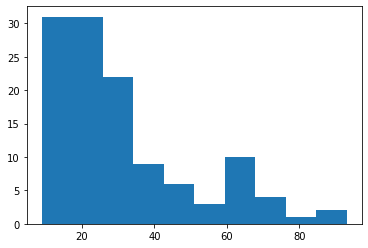

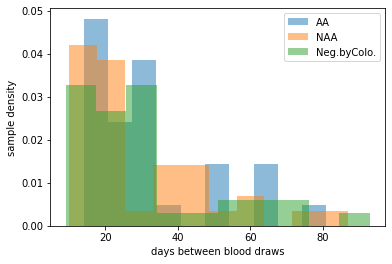

In [64]:
# Extract time btw blood draws
pid_to_draw_int ={}
for pid, df in df_olink_paired.groupby(["patient_id"]):
    assert len(df)==2
    
    post_draw = df.loc[df["blood_draw_relative_to_tx"]=="Post-Colonoscopy","draw_date"].values[0]
    #print(post_draw)
    a,b,c = [int(x) for x in post_draw.split("-")]
    post_draw = datetime.datetime(a,b,c)
    
    pre_draw = df.loc[df["blood_draw_relative_to_tx"]=="Pre-Colonoscopy","draw_date"].values[0]
    a,b,c = [int(x) for x in pre_draw.split("-")]
    pre_draw = datetime.datetime(a,b,c)
    
    interval = post_draw - pre_draw
    #print(interval.days)
    pre_sid = df.loc[df["blood_draw_relative_to_tx"]=="Pre-Colonoscopy","sample_id"].values
    post_sid = df.loc[df["blood_draw_relative_to_tx"]=="Post-Colonoscopy","sample_id"].values
    
    pid_to_draw_int[pid]=(int(pre_sid), int(post_sid), interval.days)
    
plt.figure()
plt.hist([x[2] for x in pid_to_draw_int.values()])
print(min([x[2] for x in pid_to_draw_int.values()]))

intv_aa = [ pid_to_draw_int[pid][2] for pid in set(df_olink_paired.loc[df_olink_paired["path_type"]=="AA", "patient_id"].values)]
print(len(intv_aa))
intv_naa = [ pid_to_draw_int[pid][2] for pid in set(df_olink_paired.loc[df_olink_paired["path_type"]=="NAA", "patient_id"].values)]
print(len(intv_naa))
intv_neg = [ pid_to_draw_int[pid][2] for pid in set(df_olink_paired.loc[df_olink_paired["path_type"]=="Negative by colonoscopy (no histopathology)", "patient_id"].values)]
print(len(intv_neg))
plt.figure()
plt.hist(intv_aa, density=True, alpha=0.5, label="AA")
plt.hist(intv_naa, density=True, alpha=0.5, label="NAA")
plt.hist(intv_neg, density=True, alpha=0.5, label="Neg.byColo.")
plt.legend()
plt.ylabel("sample density")
plt.xlabel("days between blood draws")

In [65]:
# Isolate the paired data AA samples data only

proteins = [f"{a}:{b}" for a,b in zip([d["Assay"] for d in mat_all.column_metadata],[d["Panel"] for d in mat_all.column_metadata])]

mat_all_combatted_aa = mat_all_combatted[[sid_to_ctype[sid]=="Colorectal Pre-Cancer" for sid in mat_all_combatted.sample_ids]]
print(mat_all_combatted_aa.shape)

df_mat_all_combatted_aa = pd.DataFrame(mat_all_combatted_aa.x, columns=proteins, index=mat_all_combatted_aa.sample_ids)
print(df_mat_all_combatted_aa.shape)
    
    

(62, 920)
(62, 920)


In [70]:
from scipy.stats import spearmanr

Text(0.02, 0.5, 'NPX change (post-pre)')

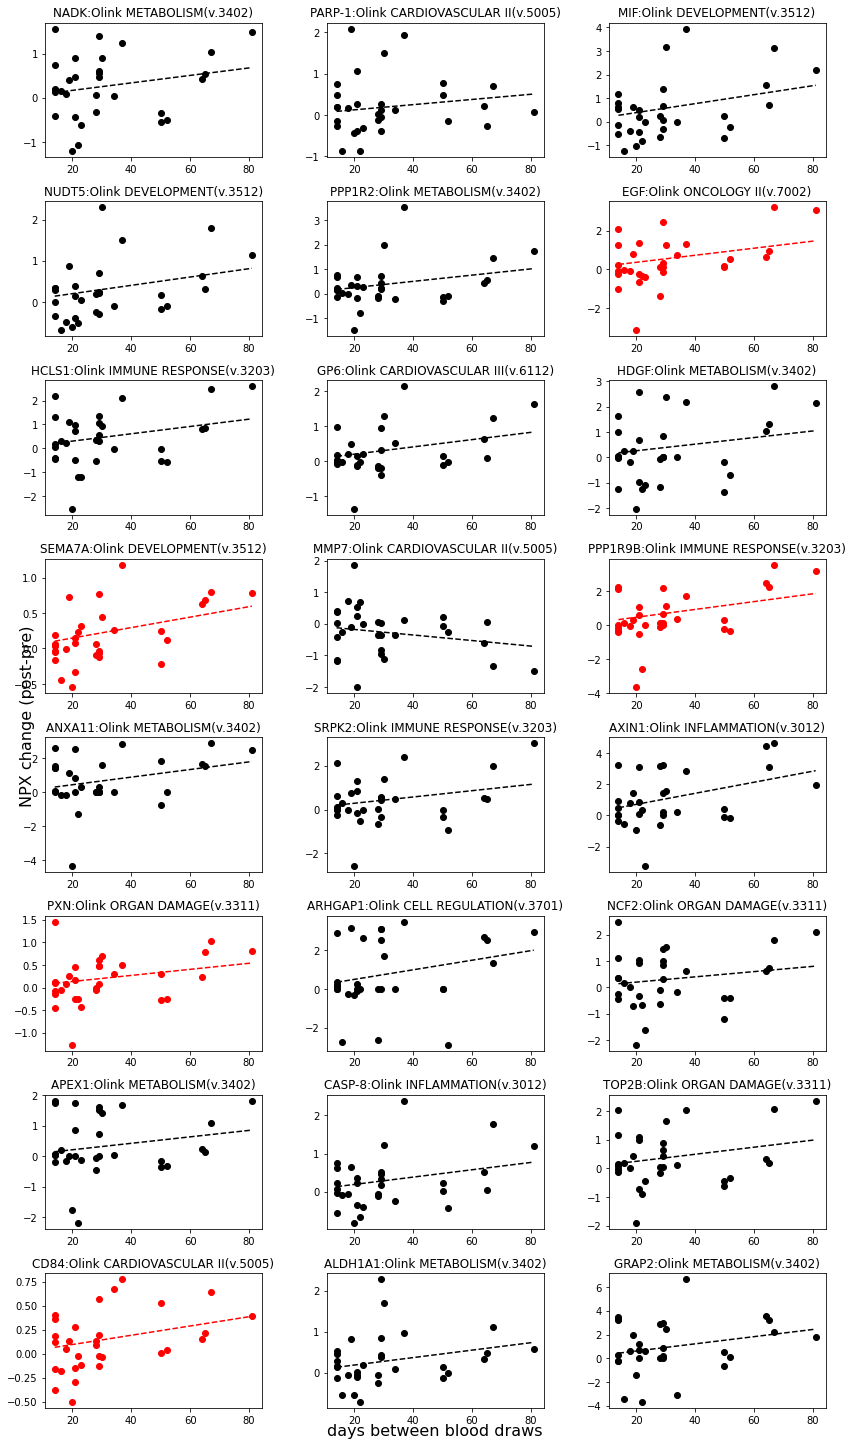

In [71]:
## plot blood draw time vs change in prot for top prots

fig, ax = plt.subplots(nrows=8,ncols=3, figsize=(12,20), sharey=True, sharex=True)

### significanly increasing or decreasing proteins
signif_prots = []

aa_pids = df_olink_paired.loc[df_olink_paired["cancer_type"]=="Colorectal Pre-Cancer","patient_id"].values

for i, prot in enumerate(de_prot_lists_combo["AA-NAA"], start=1):
    npx_diffs = []
    intervals = []
    for pid in set(aa_pids):
        pre_sid = pid_to_draw_int[pid][0]
        npx_pre = df_mat_all_combatted_aa.loc[pre_sid,prot]
        post_sid = pid_to_draw_int[pid][1]
        npx_post = df_mat_all_combatted_aa.loc[post_sid,prot]
        npx_diffs.append(npx_post-npx_pre)
        intervals.append(pid_to_draw_int[pid][2])
        #print({pid})
        #print(f"pre {npx_pre}")
        #print(f"post {npx_post}")
    #break
    
    #print((npx_diffs))
    #print((intervals))
    #num_post_lessthan_pre = sum([x>0 for x in npx_diffs])#/float(len(npx_diffs))
    #if num_post_lessthan_pre >= 16: #23: # this is 75% of the 31 AA samples
    plt.subplot(8,3,i)
    model = sm.OLS(endog=npx_diffs, exog=intervals).fit()  # dependent var is endog
    #print(model.summary())
    rho, p_val = spearmanr(npx_diffs,intervals)
    color = 'black'
    #if model.f_pvalue <=0.05:
    if p_val <=0.05:
        signif_prots.append(prot)
        #if model.params[0] > 0: # coeff (slope) is greater than 0, prot increasing
        if rho > 0:
            color = 'red'
        else:
            color = 'blue'
    plt.plot(sorted(intervals), model.predict(sorted(intervals)), color=color, linestyle="--")
    plt.scatter(intervals, npx_diffs, color=color)
    #plt.xlim((0,20))
    plt.title(prot)
fig.tight_layout()
fig.text(0.5, 0, "days between blood draws", ha='center', fontsize=16)
fig.text(0.02, 0.5, "NPX change (post-pre)", va='center', rotation='vertical', fontsize=16)
#ax.set_ylabel(, fontsize=16)
#ax.set_xlabel()

#plt.savefig("./de_prot_aa_naa_vs_time.jpg")


num patients: 34
FAP:Olink CARDIOMETABOLIC(v.3603): [-0.02971943]
PDGFRB:Olink DEVELOPMENT(v.3512): [-0.00500251]
XG:Olink DEVELOPMENT(v.3512): [-0.00581342]
ARSA:Olink DEVELOPMENT(v.3512): [-0.00739209]
GLB1:Olink IMMUNE RESPONSE(v.3203): [-0.00900912]
IL-24:Olink INFLAMMATION(v.3012): [-0.01826335]
DNER:Olink INFLAMMATION(v.3012): [-0.00550293]
IFN-gamma-R1:Olink ONCOLOGY II(v.7002): [-0.0069653]
ITGAV:Olink ONCOLOGY II(v.7002): [-0.00666301]
LYPD3:Olink ONCOLOGY II(v.7002): [-0.00565947]
ERBB2:Olink ONCOLOGY II(v.7002): [-0.00804828]
FADD:Olink ONCOLOGY II(v.7002): [-0.01733053]
ITGB5:Olink ONCOLOGY II(v.7002): [-0.00744924]
FGF-BP1:Olink ONCOLOGY II(v.7002): [-0.0069955]
RSPO3:Olink ONCOLOGY II(v.7002): [-0.00966862]
PDGFC:Olink ORGAN DAMAGE(v.3311): [-0.02820284]
ENTPD6:Olink ORGAN DAMAGE(v.3311): [-0.00610872]
RARRES1:Olink ORGAN DAMAGE(v.3311): [-0.00348019]


Text(0.02, 0.5, 'NPX change (post-pre)')

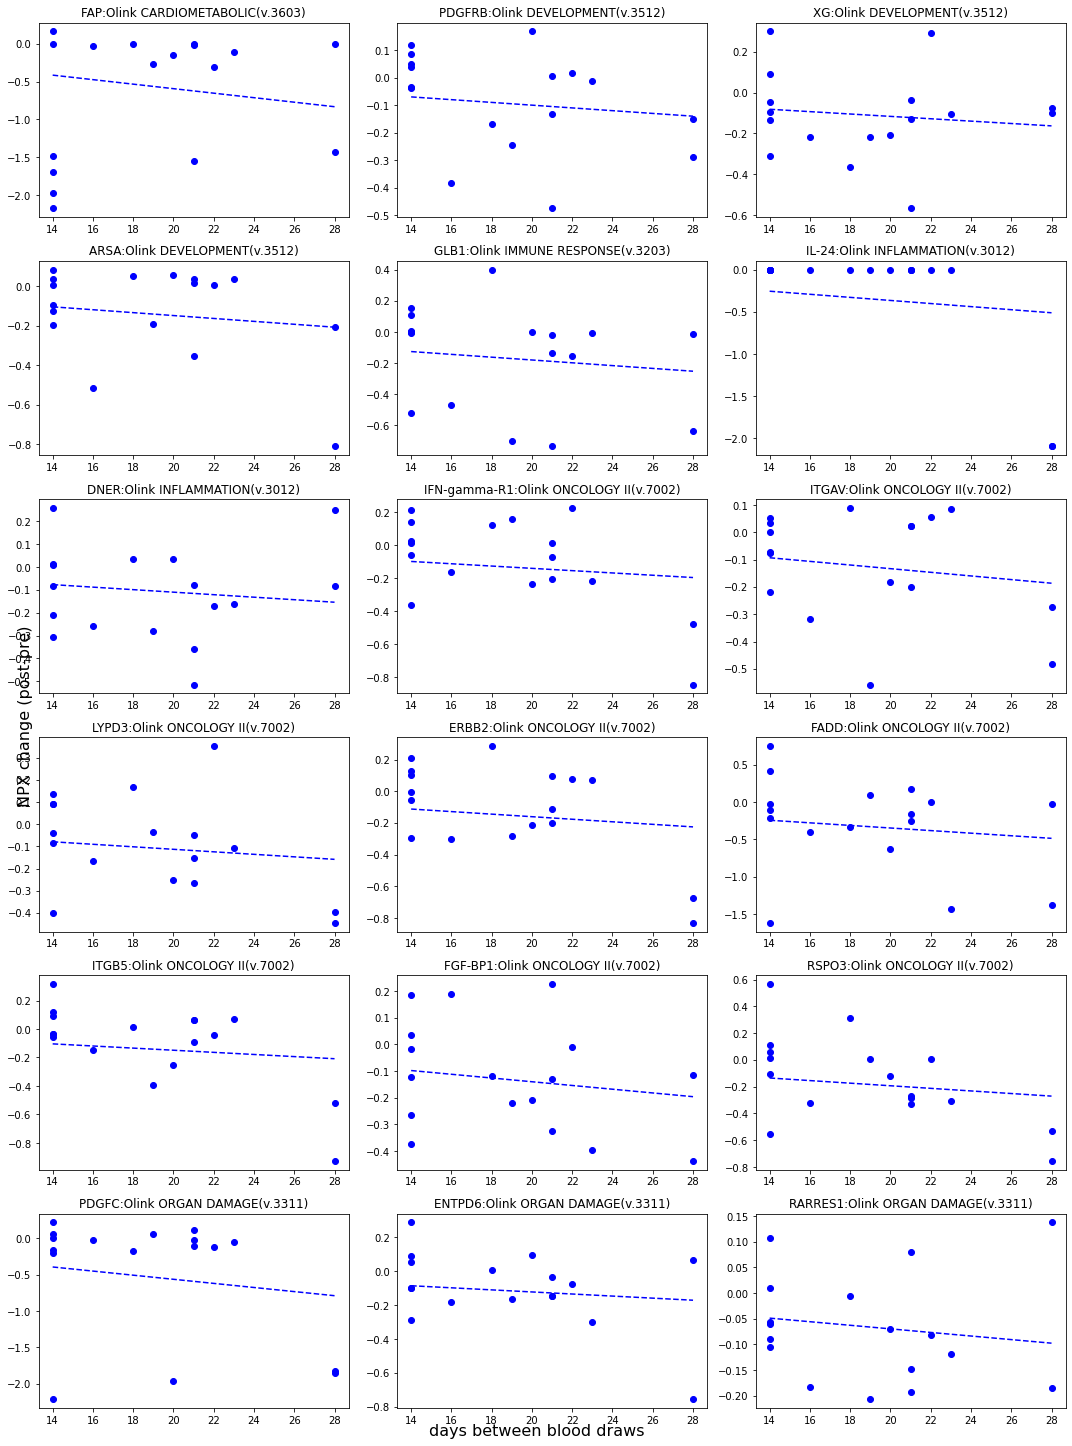

In [67]:
## look for signif decreasing proteins in aa 

MAX_DAYS = 28

## plot blood draw time vs change in prot for top prots
proteins = [f"{a}:{b}" for a,b in zip([d["Assay"] for d in mat_all_combatted.column_metadata],[d["Panel"] for d in mat_all_combatted.column_metadata])]
fig, ax = plt.subplots(nrows=5,ncols=2, figsize=(15,20), sharey=True, sharex=True)

### significanly increasing or decreasing proteins
signif_prots = []

aa_pids = df_olink_paired.loc[df_olink_paired["path_type"]=="AA","patient_id"].values

aa_pids = [pid for pid in aa_pids if pid_to_draw_int[pid][2]<=MAX_DAYS]
print(f"num patients: {len(aa_pids)}")

i = 0
for prot in proteins: #
    npx_diffs = []
    intervals = []
    for pid in set(aa_pids):
        pre_sid = pid_to_draw_int[pid][0]
        npx_pre = df_mat_all_combatted_aa.loc[pre_sid,prot]
        post_sid = pid_to_draw_int[pid][1]
        npx_post = df_mat_all_combatted_aa.loc[post_sid,prot]
        npx_diffs.append(npx_post-npx_pre)
        intervals.append(pid_to_draw_int[pid][2])
        #print({pid})
        #print(f"pre {npx_pre}")
        #print(f"post {npx_post}")
    #break
    
    #print((npx_diffs))
    #print((intervals))
    model = sm.OLS(endog=npx_diffs,exog=intervals).fit()
    #print(model.summary())
    
    color = 'black'
    if model.f_pvalue <=0.05:
        
        if model.params[0] > 0: # coeff (slope) is greater than 0, prot increasing
            color = 'red'
        else:
            signif_prots.append(prot)
            color = 'blue'
            print(f"{prot}: {model.params}")
            #print(model.summary())
            i += 1
            plt.subplot(6,3,i)
            #sns.regplot(x=intervals, y=npx_diffs, color=color) # this is really buggy for some reason
            plt.plot(sorted(intervals), model.predict(sorted(intervals)), color=color, linestyle="--")
            plt.scatter(intervals, npx_diffs, color=color)
            plt.title(prot, fontsize=12)
fig.tight_layout()
fig.text(0.5, 0, "days between blood draws", ha='center', fontsize=16)
fig.text(0.02, 0.5, "NPX change (post-pre)", va='center', rotation='vertical', fontsize=16)
#ax.set_ylabel(, fontsize=16)
#ax.set_xlabel()

#plt.savefig("./all_decr_prot_vs_time_in_aa.jpg")

10
None
Confusion Matrix
        pred.0  pred.1
true.0     293     224
true.1      41      32
avg. AUC: 0.508
avg accuracy: 0.551


'\nConfusion Matrix (18 prots, 21 days)\n        pred.0  pred.1\ntrue.0     323     194\ntrue.1      37      36\navg. AUC: 0.566\navg accuracy: 0.608\n\n\n'

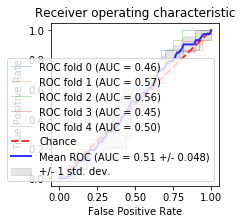

In [39]:
# predict on decreasing proteins 
print(len(signif_prots))
X = df_dc_combatted_aa_neg_F[signif_prots]
y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y])[nonpair_samples]

coefs = cross_validate(np.array(X),np.array(y))
'''
Confusion Matrix (18 prots, 28 days)
        pred.0  pred.1
true.0     323     194
true.1      37      36
avg. AUC: 0.566
avg accuracy: 0.608

Confusion Matrix (10 prots, 21 days)
        pred.0  pred.1
true.0     293     224
true.1      41      32
avg. AUC: 0.508
avg accuracy: 0.551
'''



Text(0, 0.5, 'number of AA pateints')

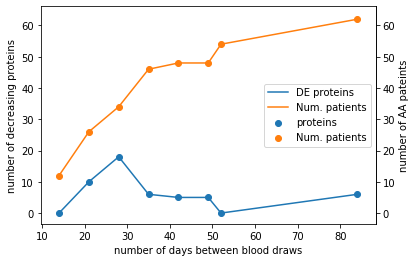

In [119]:
# plot num days vs. num DE prots and num patients

fig, ax = plt.subplots()
ax.plot([14,21,28,35,42,49,52,84], [0,10,18,6,5,5,0,6], label="DE proteins", linestyle="-")
ax.scatter([14,21,28,35,42,49,52,84], [0,10,18,6,5,5,0,6], label="proteins", linestyle="-")
secaxy = ax.secondary_yaxis('right')
ax.plot([14,21,28,35,42,49,52,84],[12,26,34,46,48,48,54,62], label="Num. patients")
ax.scatter([14,21,28,35,42,49,52,84],[12,26,34,46,48,48,54,62], label="Num. patients")
plt.legend()
ax.set_ylabel("number of decreasing proteins")
ax.set_xlabel("number of days between blood draws")
secaxy.set_ylabel("number of AA pateints")



## combat normalize for tube type

In [19]:
from pineapple.contrib.components.transformers.common.combat_transformer import CombatTransformer

In [103]:
# DC1 and DC2 DATA

# 621 samples
DC1_tcs = ("colorectal_healthy_olink_discovery1h",
           "colorectal_cancer_olink_discovery1h",
           "colorectal_benign_olink_discovery1h",
           "colorectal_healthy_olink_discovery1h_panelofneg",
           "colorectal_precancer_olink_discovery1h"
          )

DC1_labels = ["healthy","cancer","benign","PoN","precancer"]
#DC1_labels = ["PoN"]

#258 samples
DC2_tcs = ("colorectal_healthy_olink_discovery2alpha_v2",
           "colorectal_cancer_olink_discovery2alpha_v2",
           "colorectal_benign_olink_discovery2alpha_v2",
           "colorectal_healthy_olink_discovery2alpha_v2_panelofneg",
            "colorectal_precancer_olink_discovery2alpha_v2")

DC2_labels = ["healthy","cancer","benign","PoN","precancer"]

feature_name = "olink_all_panels_disc2/v1"


mat_dc = mf.create_from_training_classes(training_classes=(DC1_tcs + DC2_tcs),
                                         feature_str=feature_name,
                                         class_labels=(DC1_labels + DC2_labels),
                                         class_filters=None
                                         )

print(mat_dc.shape)

(879, 920)


In [23]:
# IS tube type there in the metadata today??????
tube_types = [d.raw_dataset_metadata['dataset']['collection_tube_type'] for d in mat_dc.dataset_metadata]
print(Counter(tube_types))

Counter({'EDTA': 621, None: 258})


In [21]:
## if tube type is missing we need this

# match dsid to tube type
from featureio import FeatureIO

with FeatureIO() as ftio:
    dsids_1 = []
    dsids_2 = []
    for tc in DC1_tcs:
        dsids_1.extend(ftio.get_datasets_for_training_class(tc))
    
    for tc in DC2_tcs:
        dsids_2.extend(ftio.get_datasets_for_training_class(tc))
        
    dsid_to_tube = dict(zip(dsids_1, ["EDTA"]*len(dsids_1)))
    dsid_to_tube.update(dict(zip(dsids_2, ["LBG"]*len(dsids_2))))
    
## Assign tube info to DC samples

for i, dsid in enumerate(mat_dc.dataset_ids):
    mat_dc.dataset_metadata[i].raw_dataset_metadata['dataset']['collection_tube_type'] = dsid_to_tube[dsid]
    
tube_types = [d.raw_dataset_metadata['dataset']['collection_tube_type'] for d in mat_dc.dataset_metadata]
print(Counter(tube_types))


Counter({'EDTA': 621, 'LBG': 258})


In [22]:
combat = CombatTransformer(covariates=['collection_tube_type'], batch = 'collection_tube_type', numerical_covariates = None)

mat_dc_imp = impute_as_mean(mat_dc, mat_dc)

print(mat_all.shape)
print(mat_dc_imp.shape)
mat_all_combatted = combat.fit(mat_dc_imp).transform(mat_all)
print(mat_all_combatted.shape)
assert [a==b for a,b in zip(mat_all.y,mat_all_combatted.y)]
assert [a==b for a,b in zip(mat_all.sample_ids,mat_all_combatted.sample_ids)]

(238, 920)
(879, 920)
(238, 920)


In [23]:
mat_dc_combatted = combat.fit(mat_dc_imp).transform(mat_dc_imp)
mat_dc_combatted.x.shape

(879, 920)

## Normalize for platelet counts (using PLNX4)

In [22]:
# for each protein, create a regression using DC1 healthies. Use that regression to predict npx vals for paired samples. 
# Calculate diff btw predicted and actual, use for modeling. do this only if platelt corr is significant

proteins = [f"{a}:{b}" for a,b in zip([d["Assay"] for d in mat_all_combatted.column_metadata],[d["Panel"] for d in mat_all_combatted.column_metadata])]

df_dc_combatted_pon = pd.DataFrame(mat_dc_combatted.x[[lb=="PoN" for lb in mat_dc_combatted.y]], columns = proteins )
print(df_dc_combatted_pon.shape)

df_all_combatted = pd.DataFrame(mat_all_combatted.x, columns = proteins)
print(df_all_combatted.shape)

def pltlt_tranform(df_combatted):
    """ 
        Adjust npx (combatted) values by taking residual value of regression of platelet correlated protein PLXNA4
        in the PoN combatted matrix of all dc1/dc2a. Only adjust when rsq >=0.95
    """
    out_cols = []
    i=0
    for prot in df_combatted.columns:
        # check if pltlt is predictive of target protein
        X = pd.DataFrame(df_dc_combatted_pon['PLXNA4:Olink IMMUNE RESPONSE(v.3203)'])
        y = df_dc_combatted_pon[prot]
        #model = lm.LinearRegression()
        #results = model.fit(X,y)
        model = sm.OLS(y,X).fit()
        if model.rsquared_adj >= 0.95: # some playing around shows this is a good cutoff , . . I think?
            i+=1
            prepost_y = df_combatted.loc[:,prot].values
            prepost_X = df_combatted['PLXNA4:Olink IMMUNE RESPONSE(v.3203)'].values
            prepost_y_pred = model.predict(prepost_X)
            prepost_resids = np.array(prepost_y) - np.array(prepost_y_pred)
            if i <5:
                #print(model.f_pvalue)
                # generate adjusted values
                plt.figure()
                plt.scatter(X.values, y)
                
                plt.figure()
                plt.scatter(prepost_X, prepost_y, color="blue")
                plt.scatter(prepost_X, prepost_y_pred, color="red")
                plt.title(prot)
                plt.xlabel("PLNX4 value")
                plt.ylabel(f"{prot}")

            out_cols.append(prepost_resids)
            continue

        else:
            out_cols.append(df_combatted.loc[:,prot].values)

    print(f"num adjusted: {i}")

    df_combatted_pltlt = pd.DataFrame(out_cols).T
    df_combatted_pltlt.columns = proteins
    df_combatted_pltlt.shape
    
    return df_combatted_pltlt
        

(92, 920)
(238, 920)


In [23]:
df_all_combatted_pltlt = pltlt_tranform(df_all_combatted)
mat_all_combatted_pltlt = mat_all_combatted.replace_x(x=np.array(df_all_combatted_pltlt))
mat_all_combatted_pltlt.shape

num adjusted: 59


(238, 920)

## Assuming all AAs and all NAAs and all dirty Negs are completely resected, how many proteins change significantly after resection?

In [24]:
from statsmodels.stats.multitest import multipletests
from scipy import stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#from matplotlib_venn import venn3
from venn import venn

ModuleNotFoundError: No module named 'venn'

In [39]:
def plot_de_prots(df_olink_paired, mat, label):   
    '''
    Args:
        df_olink_paired: data frame containing all sampleids and patient ids matched with correct cancer type adn tissue dispo
        mat = mf object containing olink data for all dataset ids in the above data frame
        
    This function will make a volcano plot of de proteins pre/post resection for each disease type. set disease type as path_type 
    or as cancer_type.
    A dict of de proteins for each dissease type will be returned
    '''
    
    de_prot_lists = {}
    p_val_dicts = {}
    for cancer_type in set(df_olink_paired[label]):
        #samples = [lb==cancer_type for lb in mat_all_ctype_labels]
        samples = [lb==cancer_type for lb in mat_all_pathtype_labels]
        
        if cancer_type=="AA-NAA":
            samples = [lb in ["AA","NAA"] for lb in mat_all_pathtype_labels]
        
        proteins = [f"{a}:{b}" for a,b in zip([d["Assay"] for d in mat.column_metadata],[d["Panel"] for d in mat.column_metadata])]
        #proteins = [d["Assay"] for d in mat_all.column_metadata]
        df = pd.DataFrame(mat.x[samples])
        df.columns = proteins
        prepost_labels = mat_all_prepost_labels[samples]
        
        # drop cols where there are only zeros
        #print(df.shape)
        #df = df.loc[:, (df != 0).any(axis=0)]
        #print(df.shape)
        
        # drop cols where there is zero variation
        print(df.shape)
        df = df.loc[:, df.std()>1e-10]
        print(df.shape)
        
        p_vals = []
        diffs = []
        U_vals = []
        for prot in df.columns:
            x = df.loc[[lb=="Pre-Colonoscopy" for lb in prepost_labels], prot].values
            y = df.loc[[lb=="Post-Colonoscopy" for lb in prepost_labels], prot].values
            if np.std(x) != 0.0 and np.std(y) != 0.0:
                #print(np.std(x))
                #print(np.std(y))
                U, p = stats.mannwhitneyu(x,y)
            else:
                U, p = np.nan, 1.0
            diffs.append(np.mean(y)-np.mean(x))
            p_vals.append(p)
            #U_vals.append(U)
        
        #print(cancer_type)
        #print(diffs)
        #print(p_vals)

        # do not adjust for mult tests
        nlog_p_vals = [-np.log10(p) for p in p_vals]
        colors = ["red" if p <= 0.01 else "blue" for p in p_vals]
        
        # adjust p-values for multiple tests ##WARN: this does crazy things . . .
        #reject, q_vals = multipletests(p_vals, 0.05, method="bonferroni")[:2]
        #log_q_vals = [-np.log10(q) for q in q_vals]
        #colors = ["red" if q <= 0.05 else "blue" for q in q_vals]

        plt.subplots(1,2, figsize=(20,5))
        
        ax = plt.subplot(121)
        ax.tick_params(labelsize=18)
        plt.scatter(diffs, nlog_p_vals, marker=".", color=colors)
        #plt.scatter(U_vals, log_q_vals, marker=".", color=colors)
        #xmin, xmax, ymin, ymax = plt.axis()
        plt.vlines(x=0, ymax=4, ymin=0, linestyles="dashed", lw=1)
        plt.ylim((0,4))
        plt.title(f"{cancer_type} n={len(df)/2}", fontsize=24)
        plt.xlim((-4, 4))
        #plt.ylim((0, ylim))
        plt.ylabel("-log10(p_val)", fontsize=24)
        plt.xlabel(f"Mean NPX diff.(post-pre)", fontsize=24)
        
        de_prot_indxs = [i for i,col in enumerate(colors) if col=="red"]
        
        plt.subplot(122)
        plt.hist(diffs)
        plt.scatter(x=[diffs[i] for i in de_prot_indxs], y = [450]*len(de_prot_indxs))
        plt.xlabel("Mean NPX diff. post/pre ")

        #n_de_prots = np.sum(np.array([x=="red" for x in colors]))
        assert len(colors)==len(df.columns)
        de_prot_lists[cancer_type] = set([df.columns[i] for i in de_prot_indxs])
        p_val_dicts[cancer_type] = dict(zip(proteins, p_vals))
        
    plt.figure()
    venn(de_prot_lists)
#     venn3([set(de_prot_lists["AA"]), set(de_prot_lists["NAA"]), set(de_prot_lists["Negative by colonoscopy (no histopathology)"])],
#          set_labels=["AA","NAA","Healthy"])
    
    return de_prot_lists, p_val_dicts

## find DE prots in raw paired data

(80, 920)
(80, 913)
(62, 920)
(62, 906)
(22, 920)
(22, 893)
(74, 920)
(74, 913)


NameError: name 'venn' is not defined

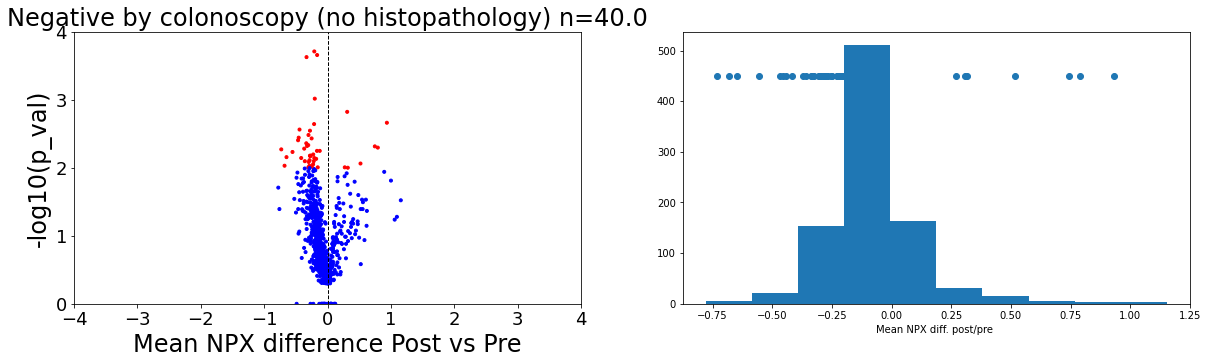

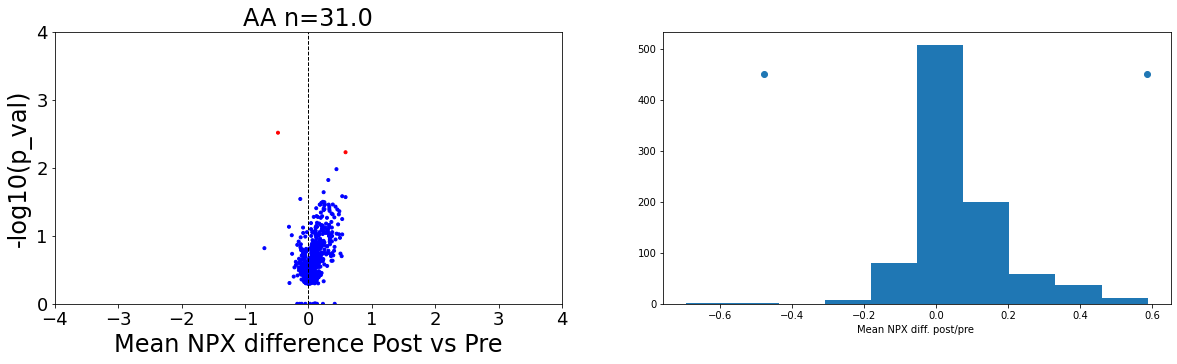

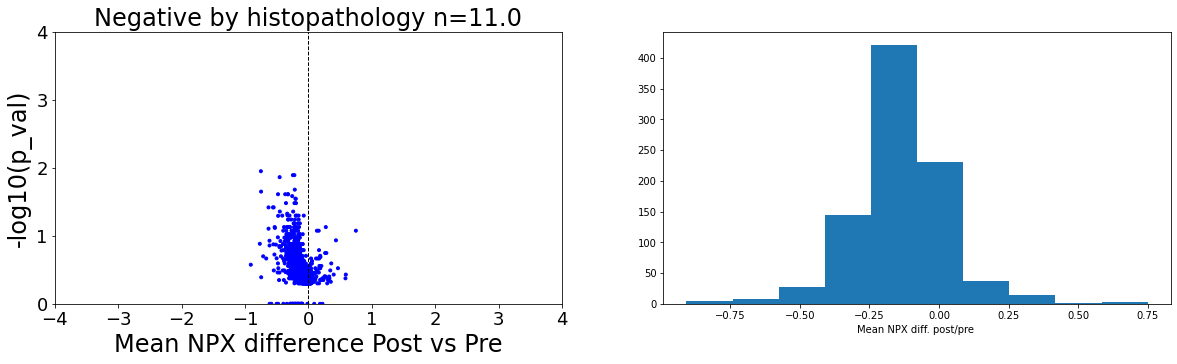

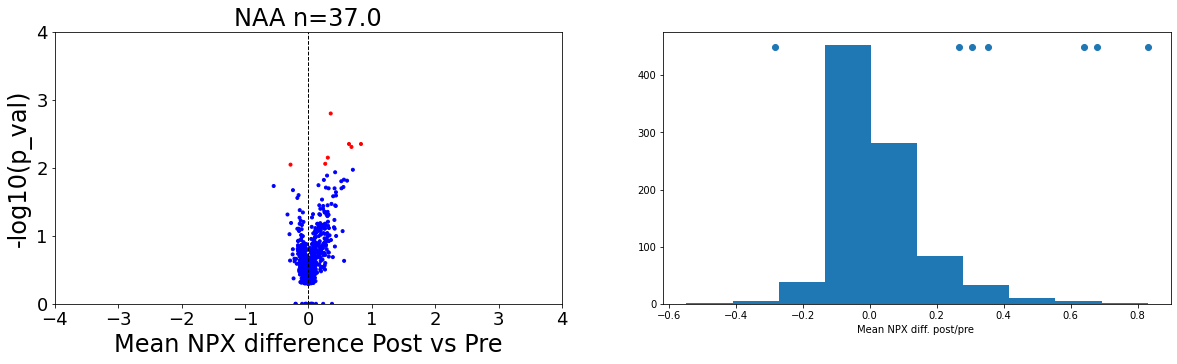

<Figure size 432x288 with 0 Axes>

In [38]:
de_prot_lists_raw = plot_de_prots(df_olink_paired, mat_all, label="path_type")

## find DE prots in combatted paired data

(80, 920)
(80, 920)
(62, 920)
(62, 906)
(22, 920)
(22, 920)
(74, 920)
(74, 920)


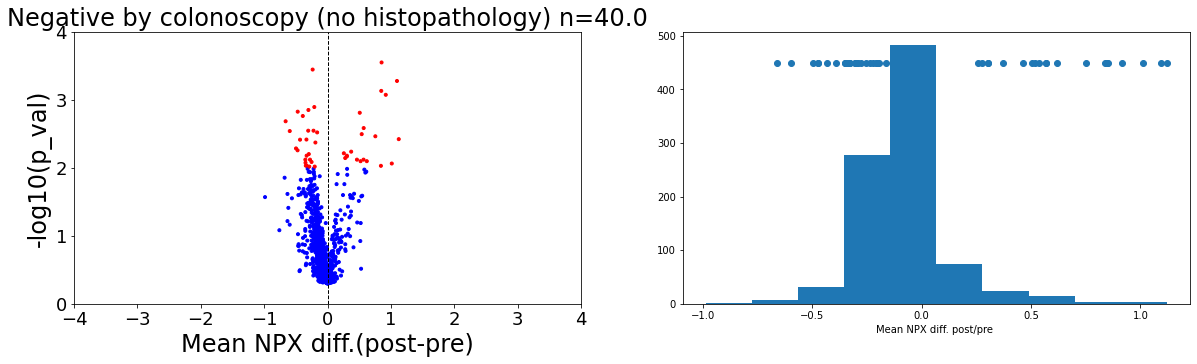

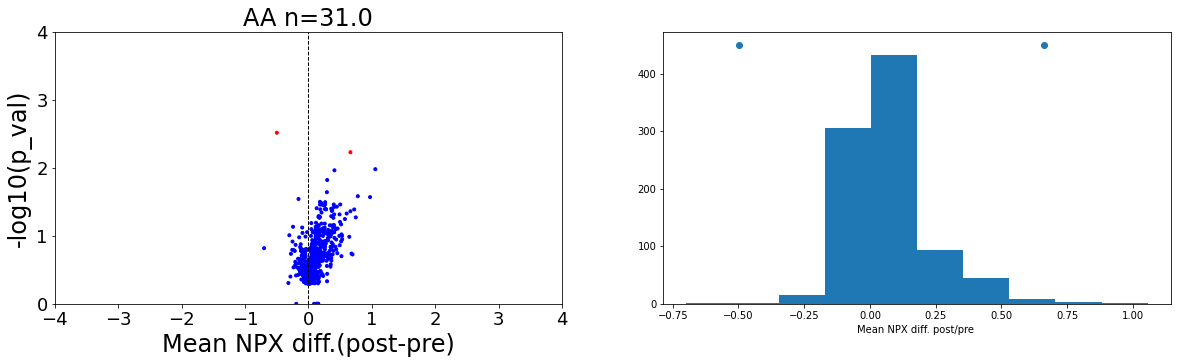

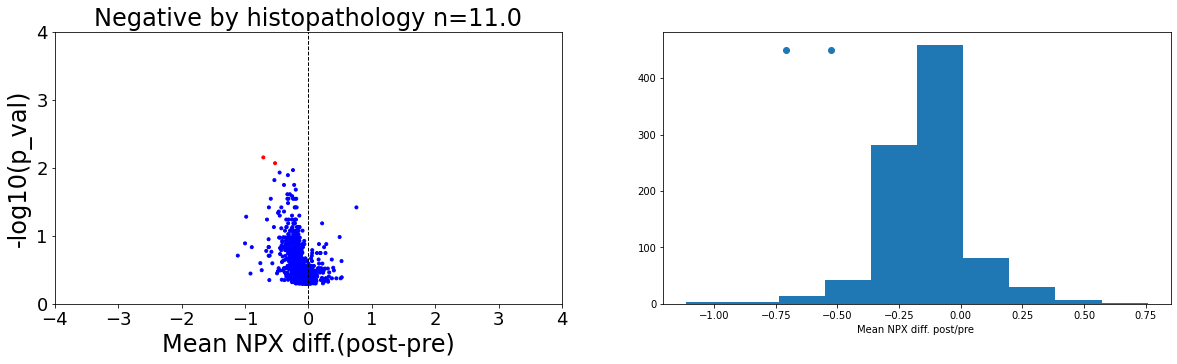

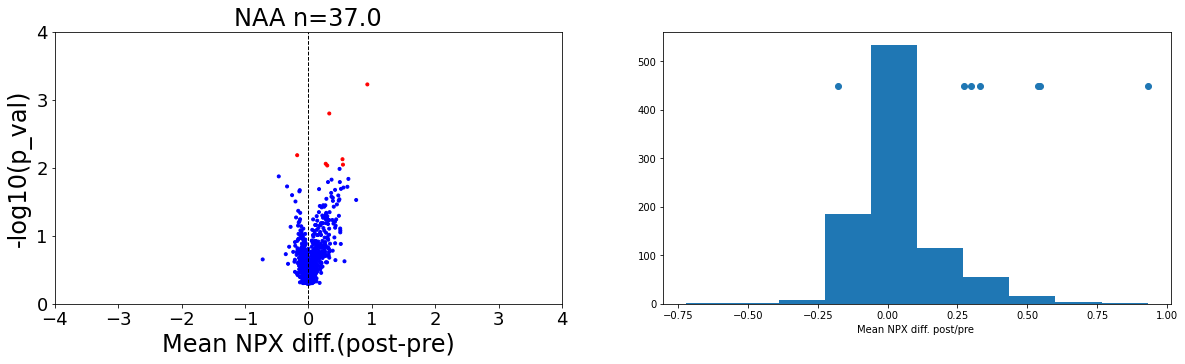

<Figure size 432x288 with 0 Axes>

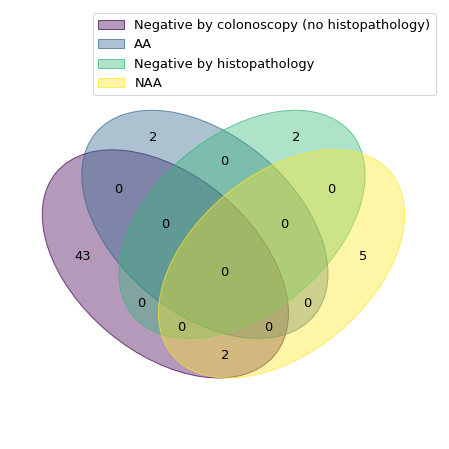

In [46]:
de_prot_lists_cmb, pvals_prots_cmb = plot_de_prots(df_olink_paired, mat_all_combatted, label="path_type")

In [49]:
len(de_prot_lists_cmb["Negative by colonoscopy (no histopathology)"])

45

## find DE prots in combatted pltlt normalized paired data

In [ ]:
de_prot_lists_pltlt = plot_de_prots(df_olink_paired, mat_all_combatted_pltlt)

## combine aa-naa in combat data and find de prots

In [41]:
combo_lab = ["AA-NAA" if lbl in ["AA","NAA"] else lbl for lbl in df_olink_paired["path_type"]]
df_olink_paired["path_type2"] = combo_lab

In [42]:
Counter(df_olink_paired["path_type2"])

Counter({'AA-NAA': 136,
         'Negative by histopathology': 22,
         'Negative by colonoscopy (no histopathology)': 80})

(80, 920)
(80, 920)
(136, 920)
(136, 920)
(22, 920)
(22, 920)


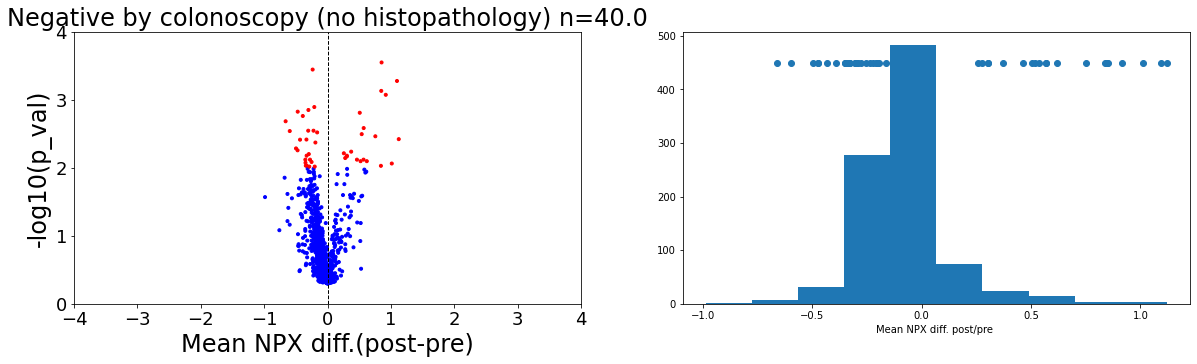

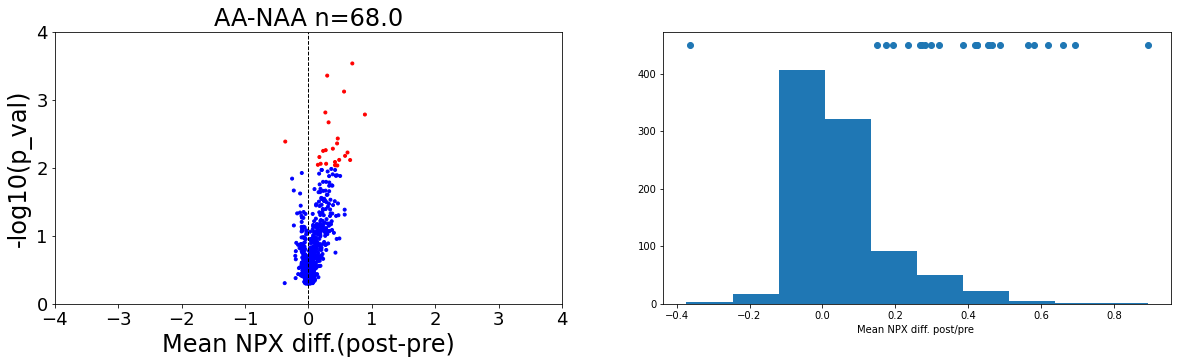

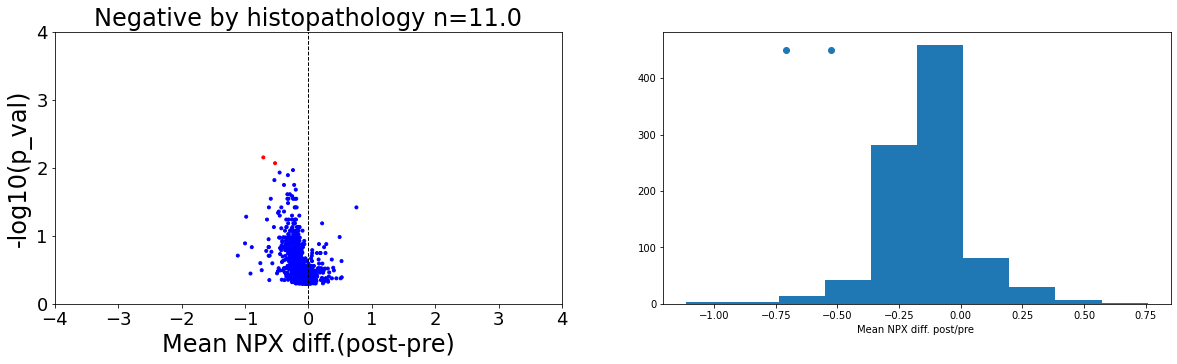

<Figure size 432x288 with 0 Axes>

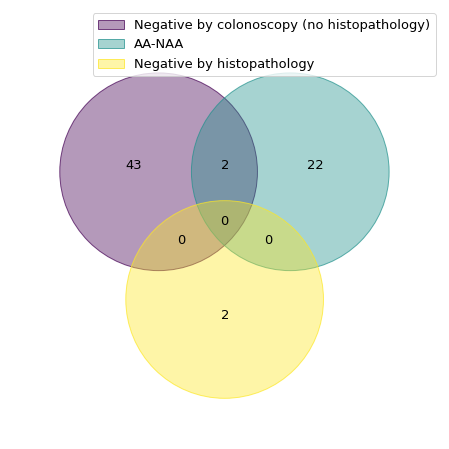

In [47]:
de_prot_lists_combo, pvals_prot_combo = plot_de_prots(df_olink_paired, mat_all_combatted, label='path_type2')

## Use de prots for prediction

In [49]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy import interp
from sklearn.metrics import auc, confusion_matrix
from sklearn.metrics import plot_roc_curve  # need pip install scikit-learn==0.22.1
from sklearn.model_selection import StratifiedKFold

In [48]:
# a function to run standard cross validation on log reg model looiking at poisson probabilities
# REF: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

classifier = LogisticRegression(C=10,
                             penalty="l2",
                             max_iter=2000,
                             solver="lbfgs",
                             class_weight="balanced")
 
def cross_validate(X, y, plot=True, name=None):
    cv = StratifiedKFold(n_splits=5)  # balanced by class
    tprs = []
    aucs = []
    coefs = []
    cv_calls = {}
    mean_fpr = np.linspace(0, 1, 100) # 100 numbers evenly split between 0 and 1
    
    fig, ax = plt.subplots(figsize=(3,3))
    for i, (train, test) in enumerate(cv.split(X,y)):  #two sets of indexes for splitting
        classifier.fit(X[train], y[train])
        coefs.append(classifier.coef_)
        
        test_labels = classifier.predict(X[test]) # each sample occurs only once as a test sample
        test_calls = dict(zip(test, test_labels))
        cv_calls.update(test_calls)

        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)   # returns obj of class sklearn.metrics.RocCurveDisplay
        # return tpr values at theoretical cumulative fpr values from 0 to 1 linear interp for cumulative fpr vs. cum tpr, 10 vals ea
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    print(f"{name}")
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr) # calc auc using points x=mean_fprs, y=mean tprs across folds
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f"Mean ROC (AUC = {np.round(mean_auc,2)} +/- {np.round(std_auc,3)})",
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1) # set vals plus 1 stdev > 1 to =1
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0) # set vals minus 1 stdev < 0 to =0
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label='+/- 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")   
    
    # conf matrix of cross-val calls
    assert len(cv_calls.keys()) == len(X), "There should be one cv call per sample in the data set"
    print("Confusion Matrix")
    cm = pd.DataFrame(confusion_matrix(y, [cv_calls[sample] for sample in range(len(X))]))
    cm.columns = ["pred.0", "pred.1"]
    cm.index = ["true.0", "true.1"]
    print(cm)
    
    mean_auc = auc(mean_fpr, mean_tpr)
    print(f"avg. AUC: {np.round(mean_auc,3)}")
    acc = (cm.iloc[0,0] + cm.iloc[1,1])/float(cm.sum().sum())
    print(f"avg accuracy: {np.round(acc,3)}")
    
    return coefs


NameError: name 'LogisticRegression' is not defined

### Cross Val combatted dc1/2 data for AA pred

In [33]:
# Isolate the DC1+2a data for cross validation
# AA and NEG samples only, not in the de prot discovery set

proteins = [f"{a}:{b}" for a,b in zip([d["Assay"] for d in mat_dc.column_metadata],[d["Panel"] for d in mat_dc.column_metadata])]

# isolate dc aa/negs 
mat_dc_combatted_aa_neg = mat_dc_combatted[[lb in ["healthy","precancer"] for lb in mat_dc_combatted.y]]
df_dc_combatted_aa_neg = pd.DataFrame(mat_dc_combatted_aa_neg.x, columns = proteins )
print(df_dc_combatted_aa_neg.shape)

# remove training samples
print(df_dc_combatted_aa_neg.shape)
####samples NOT in the univariatate analysis####
nonpair_samples = [sid not in df_olink_paired["sample_id"].values for sid in mat_dc_combatted_aa_neg.sample_ids]
####

df_dc_combatted_aa_neg_F = df_dc_combatted_aa_neg[nonpair_samples]
print(df_dc_combatted_aa_neg_F.shape)

(618, 920)
(618, 920)
(590, 920)


In [43]:
Counter(mat_dc_combatted_aa_neg.y)

Counter({'precancer': 87, 'healthy': 531})

Confusion Matrix
        pred.0  pred.1
true.0     318     199
true.1      37      36


'\nConfusion Matrix\n        pred.0  pred.1\ntrue.0     319     198\ntrue.1      37      36\n'

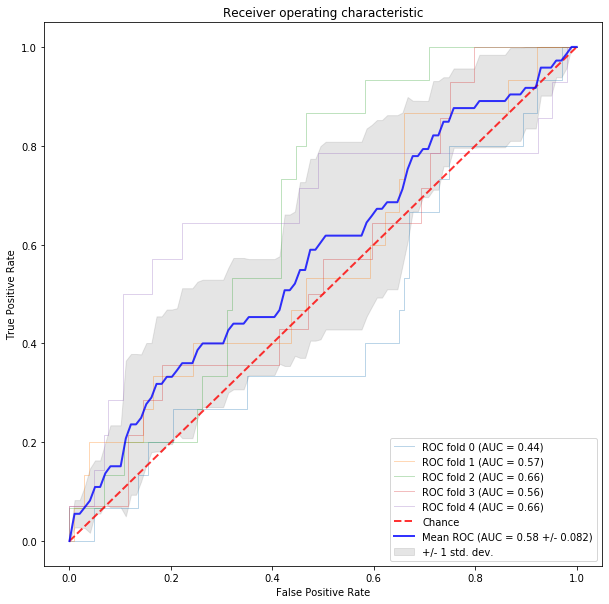

In [75]:
# Predict AA using Chen 2 proteins in LogReg (combatted data)

X = df_dc_combatted_aa_neg_F[["FASLG:Olink ONCOLOGY II(v.7002)","GDF-15:Olink CARDIOVASCULAR III(v.6112)"]]
y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y])[nonpair_samples]

coefs = cross_validate(np.array(X),np.array(y))
'''
Confusion Matrix
        pred.0  pred.1
true.0     318     199
true.1      37      36

AUC: 0.58
'''

Confusion Matrix
        pred.0  pred.1
true.0     303     214
true.1      39      34


'Confusion Matrix\n        pred.0  pred.1\ntrue.0     302     215\ntrue.1      38      35'

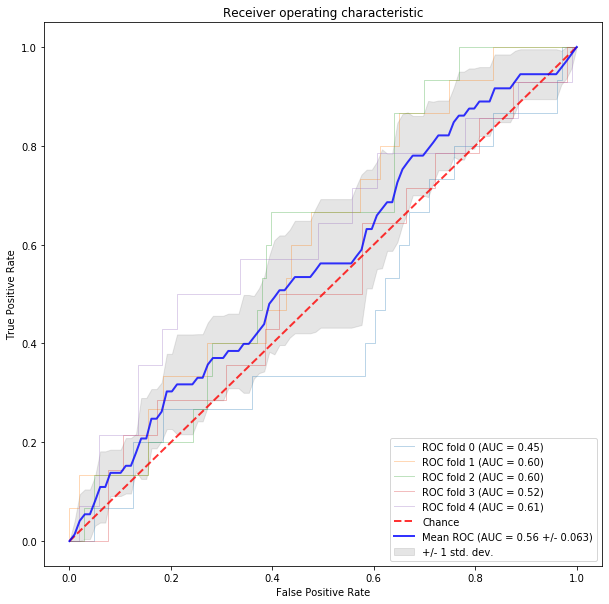

In [76]:
# Predict AA using Chen 2 proteins plus AA resection outliers
X = df_dc_combatted_aa_neg_F[["FASLG:Olink ONCOLOGY II(v.7002)",
                             "GDF-15:Olink CARDIOVASCULAR III(v.6112)",
                             "FAP:Olink CARDIOMETABOLIC(v.3603)",
                             "ANXA11:Olink METABOLISM(v.3402)"]]
coefs = cross_validate(np.array(X),np.array(y))

###
'''Confusion Matrix
        pred.0  pred.1
true.0     303     214
true.1      39      34

AUC:0.56
'''

Confusion Matrix
        pred.0  pred.1
true.0     234     283
true.1      37      36


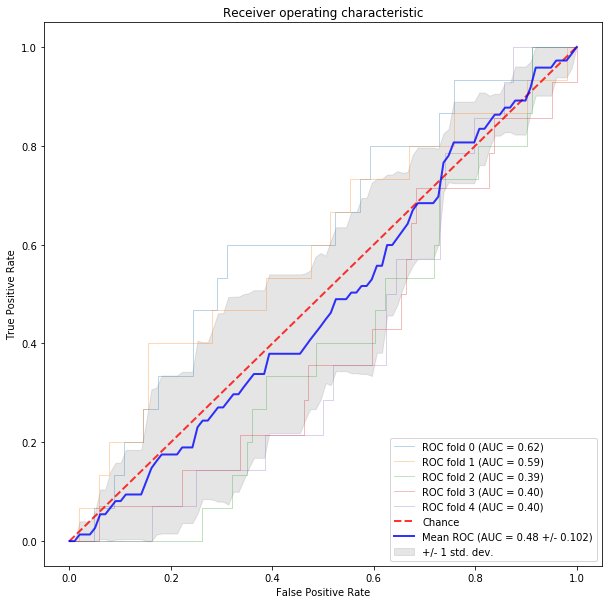

In [77]:
# Predict AA using 2 AA resection outliers only
X = df_dc_combatted_aa_neg_F[["FAP:Olink CARDIOMETABOLIC(v.3603)",
                             "ANXA11:Olink METABOLISM(v.3402)"]]
coefs = cross_validate(np.array(X),np.array(y))

###
'''Confusion Matrix
        pred.0  pred.1
true.0     234     283
true.1      37      36

AUC: 0.48'''

### Cross Val combatted and platelet corr dc1/2 data for AA pred

In [ ]:
# Isolate the DC data for cross validation with pltlt corrd
mat_dc_combatted_aa_neg = mat_dc_combatted[[lb in ["healthy","precancer"] for lb in mat_dc_combatted.y]]
df_dc_combatted_aa_neg = pd.DataFrame(mat_dc_combatted_aa_neg.x, columns = proteins )
print(df_dc_combatted_aa_neg.shape)

# adjust data for platelets
df_dc_combatted_aa_neg_pltlt = pltlt_tranform(df_dc_combatted_aa_neg)
df_dc_combatted_aa_neg_pltlt_F = df_dc_combatted_aa_neg_pltlt[nonpair_samples]

In [ ]:
## cross validate 2-protein model on double normalized data
X = df_dc_combatted_aa_neg_pltlt_F[["FASLG:Olink ONCOLOGY II(v.7002)","GDF-15:Olink CARDIOVASCULAR III(v.6112)"]]
y = [ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y]
y = np.array(y)[nonpair_samples]

coefs = cross_validate(np.array(X), np.array(y))
'''
Confusion Matrix
        pred.0  pred.1
true.0     319     198
true.1      37      36
'''

### CV with 4 proteins

In [ ]:
X = df_dc_combatted_non_pon_pltlt_F[["FASLG:Olink ONCOLOGY II(v.7002)",
                                   "GDF-15:Olink CARDIOVASCULAR III(v.6112)",
                                   "FAP:Olink CARDIOMETABOLIC(v.3603)",
                                   "ANXA11:Olink METABOLISM(v.3402)"]]
y = [ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y]

coefs = cross_validate(np.array(X), np.array(y))

### CV combat data using AA-NAA de prots to predict

In [86]:
list(de_prot_lists_combo["AA-NAA"])

['ANXA11:Olink METABOLISM(v.3402)',
 'EGF:Olink ONCOLOGY II(v.7002)',
 'MIF:Olink DEVELOPMENT(v.3512)',
 'GP6:Olink CARDIOVASCULAR III(v.6112)',
 'NADK:Olink METABOLISM(v.3402)',
 'PPP1R9B:Olink IMMUNE RESPONSE(v.3203)',
 'ARHGAP1:Olink CELL REGULATION(v.3701)',
 'GRAP2:Olink METABOLISM(v.3402)',
 'SRPK2:Olink IMMUNE RESPONSE(v.3203)',
 'NUDT5:Olink DEVELOPMENT(v.3512)',
 'MMP7:Olink CARDIOVASCULAR II(v.5005)',
 'TOP2B:Olink ORGAN DAMAGE(v.3311)',
 'AXIN1:Olink INFLAMMATION(v.3012)',
 'PXN:Olink ORGAN DAMAGE(v.3311)',
 'CD84:Olink CARDIOVASCULAR II(v.5005)',
 'NCF2:Olink ORGAN DAMAGE(v.3311)',
 'SEMA7A:Olink DEVELOPMENT(v.3512)',
 'APEX1:Olink METABOLISM(v.3402)',
 'CASP-8:Olink INFLAMMATION(v.3012)',
 'HDGF:Olink METABOLISM(v.3402)',
 'PPP1R2:Olink METABOLISM(v.3402)',
 'ALDH1A1:Olink METABOLISM(v.3402)',
 'PARP-1:Olink CARDIOVASCULAR II(v.5005)',
 'HCLS1:Olink IMMUNE RESPONSE(v.3203)']

(590, 26)
(590,)
Confusion Matrix
        pred.0  pred.1
true.0     350     167
true.1      34      39


'\nConfusion Matrix\n        pred.0  pred.1\ntrue.0     327     190\ntrue.1      38      35\n'

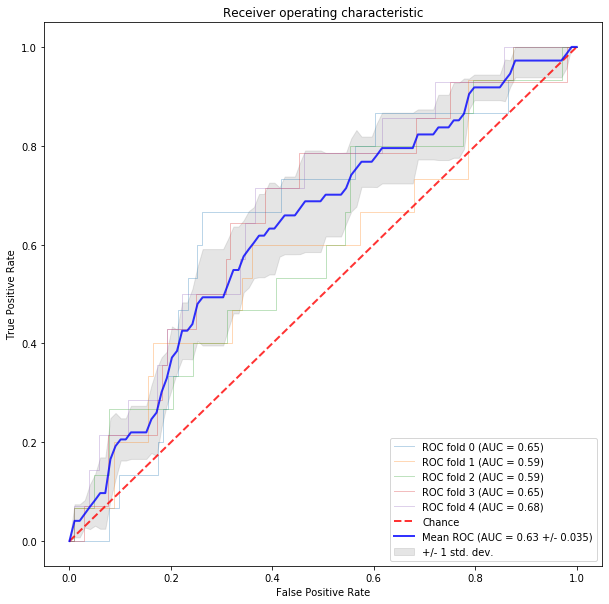

In [81]:
## try a model with all the de NAA-AA proteins plus chen2

X = df_dc_combatted_aa_neg_F[["FASLG:Olink ONCOLOGY II(v.7002)",
                                  "GDF-15:Olink CARDIOVASCULAR III(v.6112)"] + 
                                   list(de_prot_lists_combo["AA-NAA"])]
y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y])[nonpair_samples]

print(X.shape)
print(y.shape)
coefs = cross_validate(np.array(X), np.array(y))
'''
Confusion Matrix
        pred.0  pred.1
true.0     350     167
true.1      34      39
AUC: 0.63
'''

In [ ]:
## try a model with all the de NAA-AA proteins minus chen2 (worse perform)

X = df_dc_combatted_aa_neg_F[list(de_prot_lists_combo["AA-NAA"])]
y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y])[nonpair_samples]

print(X.shape)
print(y.shape)
coefs = cross_validate(np.array(X), np.array(y))
'''Confusion Matrix
        pred.0  pred.1
true.0     339     178
true.1      33      40
AUC:0.63
'''

In [47]:
print(signif_prots)

['CASP-8:Olink INFLAMMATION(v.3012)', 'CD84:Olink CARDIOVASCULAR II(v.5005)', 'SRPK2:Olink IMMUNE RESPONSE(v.3203)', 'ANXA11:Olink METABOLISM(v.3402)', 'ALDH1A1:Olink METABOLISM(v.3402)', 'TOP2B:Olink ORGAN DAMAGE(v.3311)', 'NADK:Olink METABOLISM(v.3402)', 'MMP7:Olink CARDIOVASCULAR II(v.5005)', 'NUDT5:Olink DEVELOPMENT(v.3512)', 'MIF:Olink DEVELOPMENT(v.3512)', 'EGF:Olink ONCOLOGY II(v.7002)', 'HCLS1:Olink IMMUNE RESPONSE(v.3203)', 'GP6:Olink CARDIOVASCULAR III(v.6112)', 'PPP1R2:Olink METABOLISM(v.3402)', 'PXN:Olink ORGAN DAMAGE(v.3311)', 'SEMA7A:Olink DEVELOPMENT(v.3512)', 'APEX1:Olink METABOLISM(v.3402)', 'GRAP2:Olink METABOLISM(v.3402)', 'HDGF:Olink METABOLISM(v.3402)', 'ARHGAP1:Olink CELL REGULATION(v.3701)', 'PPP1R9B:Olink IMMUNE RESPONSE(v.3203)', 'AXIN1:Olink INFLAMMATION(v.3012)']


(590, 18)
(590,)
None
Confusion Matrix
        pred.0  pred.1
true.0     333     184
true.1      36      37
avg. AUC: 0.613
avg accuracy: 0.627


'\nConfusion Matrix\n        pred.0  pred.1\ntrue.0     333     184\ntrue.1      36      37\navg. AUC: 0.613\navg accuracy: 0.627\n'

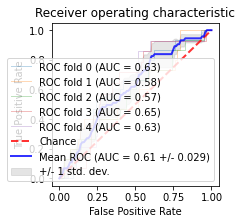

In [45]:
## try a model with the de NAA-AA proteins that signif change with time  (about the same perform)

X = df_dc_combatted_aa_neg_F[signif_prots]
y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y])[nonpair_samples]

print(X.shape)
print(y.shape)
coefs = cross_validate(np.array(X), np.array(y))
'''
Confusion Matrix
        pred.0  pred.1
true.0     333     184
true.1      36      37
avg. AUC: 0.613
avg accuracy: 0.627
'''

(590, 3)
(590,)
None
Confusion Matrix
        pred.0  pred.1
true.0     312     205
true.1      42      31
avg. AUC: 0.549
avg accuracy: 0.581


'\nConfusion Matrix\n        pred.0  pred.1\ntrue.0     271     246\ntrue.1      45      28\navg. AUC: 0.432\navg accuracy: 0.507\n'

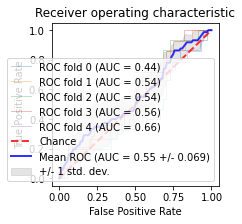

In [59]:
## try a model with the de NAA-AA proteins that signif DEecrease with time 

X = pd.DataFrame(df_dc_combatted_aa_neg_F['MMP7:Olink CARDIOVASCULAR II(v.5005)'])
y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y])[nonpair_samples]

print(X.shape)
print(y.shape)
coefs = cross_validate(np.array(X), np.array(y))
'''
Confusion Matrix
        pred.0  pred.1
true.0     271     246
true.1      45      28
avg. AUC: 0.432
avg accuracy: 0.507
'''

## increase number of prots used for prediciton systematiclaly

[('TIMD4:Olink CARDIOMETABOLIC(v.3603)', 0.0030361628796389184), ('APLP1:Olink METABOLISM(v.3402)', 0.005882931747947798)]
Model of top 2 prots
Confusion Matrix
        pred.0  pred.1
true.0     258     259
true.1      40      33
avg. AUC: 0.456
avg accuracy: 0.493
[('TIMD4:Olink CARDIOMETABOLIC(v.3603)', 0.0030361628796389184), ('APLP1:Olink METABOLISM(v.3402)', 0.005882931747947798), ('IL-17C:Olink INFLAMMATION(v.3012)', 0.0104390729627839), ('IGFBPL1:Olink METABOLISM(v.3402)', 0.010847219744173646)]
Model of top 4 prots
Confusion Matrix
        pred.0  pred.1
true.0     303     214
true.1      34      39
avg. AUC: 0.589
avg accuracy: 0.58
[('TIMD4:Olink CARDIOMETABOLIC(v.3603)', 0.0030361628796389184), ('APLP1:Olink METABOLISM(v.3402)', 0.005882931747947798), ('IL-17C:Olink INFLAMMATION(v.3012)', 0.0104390729627839), ('IGFBPL1:Olink METABOLISM(v.3402)', 0.010847219744173646), ('KLK10:Olink METABOLISM(v.3402)', 0.01507552692284554), ('CPA1:Olink CARDIOVASCULAR III(v.6112)', 0.0227956

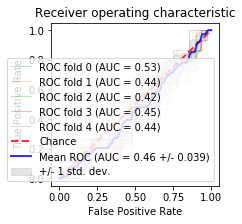

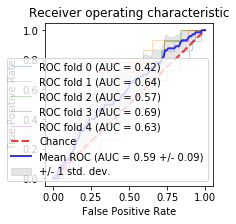

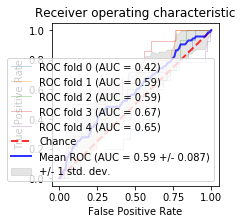

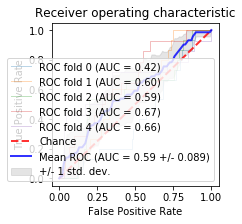

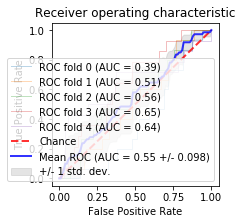

In [152]:
## use more AA pre/post prots for prediction of AA:
prots_sort = list(pvals_prots_cmb["AA"].items())
prots_sort.sort(key=lambda x: x[1])  ## the log p vals of some of these is -0.0, I think b/c of float error

for n in [2,4,6,8,10]:
    top_prots = prots_sort[0:n]
    print(top_prots)
    X = df_dc_combatted_aa_neg_F[[x[0] for x in top_prots]]
    y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_neg.y])[nonpair_samples]
    coefs = cross_validate(np.array(X), np.array(y), plot=False, name=f"Model of top {n} prots")




## predict on AA-NAA

In [154]:
# isolate dc aa/naa/neg 
mat_dc_combatted_aa_naa_neg = mat_dc_combatted[[lb in ["healthy","precancer","benign"] for lb in mat_dc_combatted.y]]
df_dc_combatted_aa_naa_neg = pd.DataFrame(mat_dc_combatted_aa_naa_neg.x, columns = proteins )
print(df_dc_combatted_aa_naa_neg.shape)

# remove training samples
print(df_dc_combatted_aa_naa_neg.shape)
####samples NOT in the univariatate analysis####
keep_samples = [sid not in df_olink_paired["sample_id"].values for sid in mat_dc_combatted_aa_naa_neg.sample_ids]
####

df_dc_combatted_aa_naa_neg_F = df_dc_combatted_aa_naa_neg[keep_samples]
print(df_dc_combatted_aa_naa_neg_F.shape)

y = np.array([ 1 if lb!="healthy" else 0 for lb in mat_dc_combatted_aa_naa_neg.y])[keep_samples]

(728, 920)
(728, 920)
(680, 920)


[('EGF:Olink ONCOLOGY II(v.7002)', 0.00029030544057197753), ('CASP-8:Olink INFLAMMATION(v.3012)', 0.0004383756980980423)]
Model of top 2 prots
Confusion Matrix
        pred.0  pred.1
true.0     336     271
true.1      41      32
avg. AUC: 0.48
avg accuracy: 0.541
[('EGF:Olink ONCOLOGY II(v.7002)', 0.00029030544057197753), ('CASP-8:Olink INFLAMMATION(v.3012)', 0.0004383756980980423), ('ANXA11:Olink METABOLISM(v.3402)', 0.0007527866759372657), ('NUDT5:Olink DEVELOPMENT(v.3512)', 0.0015294409691835034), ('AXIN1:Olink INFLAMMATION(v.3012)', 0.0016388167154645123), ('NADK:Olink METABOLISM(v.3402)', 0.0021362950090627435)]
Model of top 6 prots
Confusion Matrix
        pred.0  pred.1
true.0     342     265
true.1      35      38
avg. AUC: 0.534
avg accuracy: 0.559
[('EGF:Olink ONCOLOGY II(v.7002)', 0.00029030544057197753), ('CASP-8:Olink INFLAMMATION(v.3012)', 0.0004383756980980423), ('ANXA11:Olink METABOLISM(v.3402)', 0.0007527866759372657), ('NUDT5:Olink DEVELOPMENT(v.3512)', 0.001529440969

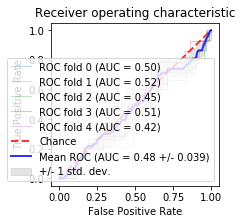

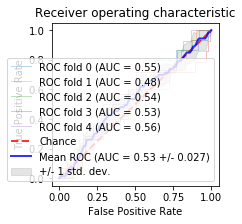

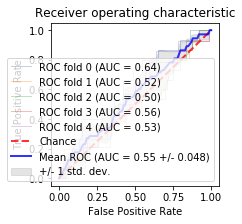

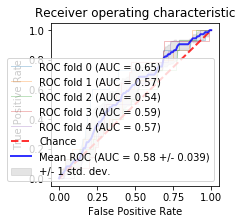

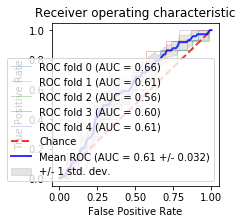

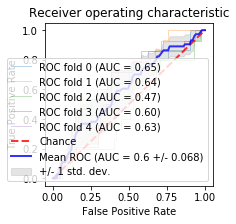

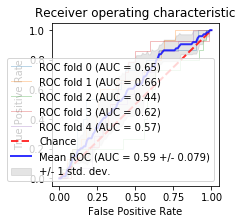

In [155]:
## use more AA-NAA pre/post prots for prediction of AA-NAA:
prots_sort = list(pvals_prot_combo["AA-NAA"].items())
prots_sort.sort(key=lambda x: x[1])  ## the log p vals of some of these is -0.0, I think b/c of float error
keep_samples = [sid not in df_olink_paired["sample_id"].values for sid in mat_dc_combatted_aa_naa_neg.sample_ids]

for n in [2,6,12,18,24,30,36]:
    top_prots = prots_sort[0:n]
    print(top_prots)
    X = df_dc_combatted_aa_naa_neg_F[[x[0] for x in top_prots]]
    y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_naa_neg.y])[keep_samples]
    coefs = cross_validate(np.array(X), np.array(y), plot=False, name=f"Model of top {n} prots")

## predict on CRC

In [156]:
## use more AA pre/post prots for prediction of CRC+AA:

# isolate dc aa/crc/neg 
mat_dc_combatted_aa_crc_neg = mat_dc_combatted[[lb in ["healthy","precancer","cancer"] for lb in mat_dc_combatted.y]]
df_dc_combatted_aa_crc_neg = pd.DataFrame(mat_dc_combatted_aa_crc_neg.x, columns = proteins )
print(df_dc_combatted_aa_crc_neg.shape)

# remove training samples
print(df_dc_combatted_aa_crc_neg.shape)
####samples NOT in the univariatate analysis####
keep_samples = [sid not in df_olink_paired["sample_id"].values for sid in mat_dc_combatted_aa_crc_neg.sample_ids]
####

df_dc_combatted_aa_crc_neg_F = df_dc_combatted_aa_crc_neg[keep_samples]
print(df_dc_combatted_aa_crc_neg_F.shape)

y = np.array([ 1 if lb!="healthy" else 0 for lb in mat_dc_combatted_aa_crc_neg.y])[keep_samples]


(677, 920)
(677, 920)
(649, 920)


Model of top 2 prots
Confusion Matrix
        pred.0  pred.1
true.0     278     239
true.1      59      73
avg. AUC: 0.556
avg accuracy: 0.541
Model of top 4 prots
Confusion Matrix
        pred.0  pred.1
true.0     310     207
true.1      62      70
avg. AUC: 0.609
avg accuracy: 0.586
Model of top 6 prots
Confusion Matrix
        pred.0  pred.1
true.0     309     208
true.1      60      72
avg. AUC: 0.6
avg accuracy: 0.587
Model of top 8 prots
Confusion Matrix
        pred.0  pred.1
true.0     309     208
true.1      61      71
avg. AUC: 0.588
avg accuracy: 0.586
Model of top 10 prots
Confusion Matrix
        pred.0  pred.1
true.0     313     204
true.1      64      68
avg. AUC: 0.58
avg accuracy: 0.587


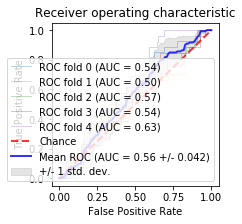

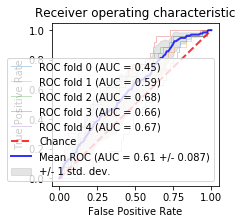

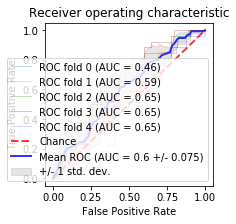

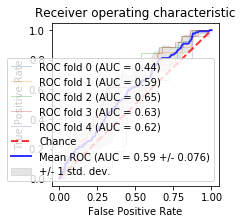

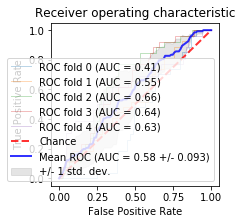

In [157]:
## use more AA pre/post prots for prediction on CRC:
prots_sort = list(pvals_prots_cmb["AA"].items())
prots_sort.sort(key=lambda x: x[1])  ## the log p vals of some of these is -0.0, I think b/c of float error

for n in [2,4,6,8,10]:
    top_prots = prots_sort[0:n]
    #print(top_prots)
    X = df_dc_combatted_aa_crc_neg_F[[x[0] for x in top_prots]]
    y = np.array([ 1 if lb!="healthy" else 0 for lb in mat_dc_combatted_aa_crc_neg.y])[keep_samples]
    coefs = cross_validate(np.array(X), np.array(y), plot=False, name=f"Model of top {n} prots")

In [158]:
# isolate dc aa/naa/crc/neg 
mat_dc_combatted_aa_naa_crc_neg = mat_dc_combatted[[lb in ["healthy","precancer","benign","cancer"] for lb in mat_dc_combatted.y]]
df_dc_combatted_aa_naa_crc_neg = pd.DataFrame(mat_dc_combatted_aa_naa_crc_neg.x, columns = proteins )
print(df_dc_combatted_aa_naa_crc_neg.shape)

# remove training samples
print(df_dc_combatted_aa_naa_crc_neg.shape)
####samples NOT in the univariatate analysis####
keep_samples = [sid not in df_olink_paired["sample_id"].values for sid in mat_dc_combatted_aa_naa_crc_neg.sample_ids]
####

df_dc_combatted_aa_naa_crc_neg_F = df_dc_combatted_aa_naa_crc_neg[keep_samples]
print(df_dc_combatted_aa_naa_crc_neg_F.shape)

y = np.array([ 1 if lb!="healthy" else 0 for lb in mat_dc_combatted_aa_naa_crc_neg.y])[keep_samples]

(787, 920)
(787, 920)
(739, 920)


[('EGF:Olink ONCOLOGY II(v.7002)', 0.00029030544057197753), ('CASP-8:Olink INFLAMMATION(v.3012)', 0.0004383756980980423)]
Model of top 2 prots
Confusion Matrix
        pred.0  pred.1
true.0     306     360
true.1      37      36
avg. AUC: 0.475
avg accuracy: 0.463
[('EGF:Olink ONCOLOGY II(v.7002)', 0.00029030544057197753), ('CASP-8:Olink INFLAMMATION(v.3012)', 0.0004383756980980423), ('ANXA11:Olink METABOLISM(v.3402)', 0.0007527866759372657), ('NUDT5:Olink DEVELOPMENT(v.3512)', 0.0015294409691835034), ('AXIN1:Olink INFLAMMATION(v.3012)', 0.0016388167154645123), ('NADK:Olink METABOLISM(v.3402)', 0.0021362950090627435)]
Model of top 6 prots
Confusion Matrix
        pred.0  pred.1
true.0     371     295
true.1      37      36
avg. AUC: 0.538
avg accuracy: 0.551
[('EGF:Olink ONCOLOGY II(v.7002)', 0.00029030544057197753), ('CASP-8:Olink INFLAMMATION(v.3012)', 0.0004383756980980423), ('ANXA11:Olink METABOLISM(v.3402)', 0.0007527866759372657), ('NUDT5:Olink DEVELOPMENT(v.3512)', 0.00152944096

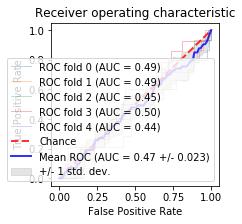

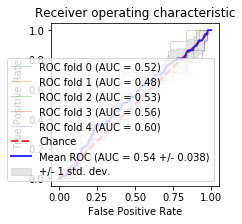

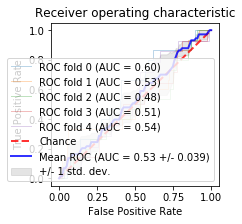

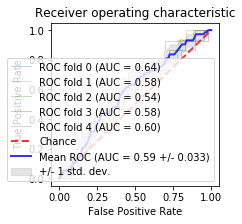

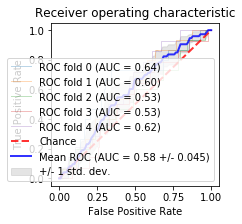

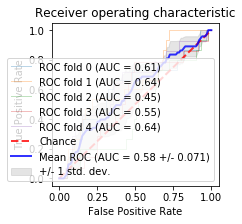

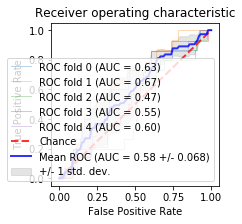

In [159]:
## use more AA-NAA pre/post prots for prediction of AA-NAA + CRC:
prots_sort = list(pvals_prot_combo["AA-NAA"].items())
prots_sort.sort(key=lambda x: x[1])  ## the log p vals of some of these is -0.0, I think b/c of float error

for n in [2,6,12,18,24,30,36]:
    top_prots = prots_sort[0:n]
    print(top_prots)
    X = df_dc_combatted_aa_naa_crc_neg_F[[x[0] for x in top_prots]]
    y = np.array([ 1 if lb=="precancer" else 0 for lb in mat_dc_combatted_aa_naa_crc_neg.y])[keep_samples]
    coefs = cross_validate(np.array(X), np.array(y), plot=False, name=f"Model of top {n} prots")

# going to try this in pineapple
# a promising yaml spec file is here:
https://storage.cloud.google.com/validation-study-dc2-alpha/protein/dc1i_aa_olink_2020_02_18_16_35_just_2_proteins_now_balance_by_pathological_subtype/experiment_spec.yaml?supportedpurview=project



In [60]:
prot_to_uniprot = dict(zip(proteins, [d["Uniprot ID"] for d in mat_all.column_metadata]))
de_prot_lists_combo_AA_NAA_uids = [prot_to_uniprot[prot] for prot in de_prot_lists_combo["AA-NAA"]]
de_prot_lists_combo_AA_NAA_uids

['Q14790',
 'Q9UIB8',
 'P78362',
 'P50995',
 'P00352',
 'Q02880',
 'O95544',
 'P09237',
 'Q9UKK9',
 'P14174',
 'P01133',
 'P14317',
 'Q9HCN6',
 'P41236',
 'P09874',
 'P49023',
 'O75326',
 'P27695',
 'O75791',
 'P19878',
 'P51858',
 'Q07960',
 'Q96SB3',
 'O15169']

In [93]:
mat_all.column_metadata[0]

{'Panel': 'Olink CARDIOMETABOLIC(v.3603)',
 'Assay': 'PRCP',
 'Uniprot ID': 'P42785',
 'OlinkID': 'OID01272',
 'LOD': 1.38034,
 'uniqAssay': 'PRCP:Olink_CARDIOMETABOLIC',
 'Ensembl ID': {'ENSG00000137509.11'},
 'ensg_ids': {'ENSG00000137509.11'}}

### Need to make new training class for testing this model

Training classes defined in this code: ~/pineapple/pineapple/contrib/components/data_factories/training_sets.py 

1. Create a filter that filters out sample IDs in paired set
2. Create a training class that is all DC1 minus those paired ones 
3. run test on new training class using cross validation
4. Results are in the file fold_metrics.json. It is test results averaged across all folds. 

In branch bgould:
NEw training class:
dc1_olink_disc_aa-neg_minus_prepost

### Trying inference with the 16 protein model:
pineapple-inference --bucket freenome-user-data-bgould --path test_aa_olink_pred_03_02_2020/dc1_minus_pre_post_aa_neg_olink_2_prot_model --dest_bucket freenome-user-data-bgould --dest_path olink_2prot_inference --test_set dc2a_olink_disc_aa-neg_minus_prepost --strategy fold_score_averaging

pineapple-inference --bucket freenome-user-data-bgould --path test_aa_olink_pred_03_02_2020/dc1_minus_pre_post_aa_neg_olink_16_prot_model --dest_bucket freenome-user-data-bgould --dest_path olink_16prot_inference --test_set dc2a_olink_disc_aa-neg_minus_prepost --strategy fold_score_averaging

In [2]:
# double the new training set has the correct samples:  # ODd it appears none of the paired aa samples are present in the dc1h olin neg-aa traininging class

mat_aa_neg_min_prepost = mf.create_from_training_set(training_set="dc1_olink_disc_aa-neg_minus_prepost",
                                                    feature_str="olink_all_panels_disc2/v1")

mat_aa_neg_min_prepost.shape



Experiment context not set, defaulting experiment_timestamp to 2020-03-03 01:15:00


(456, 920)

In [3]:
mat = mf.create_from_training_set(training_set="dc1h-olink-neg-aa",
                                                    feature_str="olink_all_panels_disc2/v1")

mat.shape

Experiment context not set, defaulting experiment_timestamp to 2020-03-03 01:15:00


(456, 920)

In [12]:
sids = df_olink_paired.loc[df_olink_paired["Analysis_Batch"].isin(["DC1","alpha","PON"]), "sample_id"].values

## look at overlap in correct model calls for the different protein models

In [15]:
import pickle

# JSJ example notebooks
# https://github.com/freenome/research_notebooks/blob/master/pineapple/methyl/dc2a/dc2a_inference_result_inspection.ipynb
# https://github.com/freenome/research_notebooks/blob/master/pineapple/methyl/dc2b/dc2b_inference_deep_dive.ipynb
#https://github.com/freenome/research_notebooks/blob/master/pineapple/methyl/asco_gi_2019/dc1_hmfc_manual_regions_20200225_deep_dive.ipynb

#or see JSJs notebook in the methyl TCGA folder on my desktop
# dc1_hmfc_manual_regions_20200225_deep_dive.ipynb
    
# get per fold results
# https://github.com/freenome/research_notebooks/blob/master/pineapple/methyl/asco_gi_2019/deep_dive_hmfc_isize_asco_gi_2019_model.ipynb [53]

#Teng's implementation
# https://github.com/freenome/teng-hsu-notebooks/blob/master/DC2b_HMFCisize_deep_dive.ipynb

In [73]:
# download model results

# DC1+DC2a cross validation
# 2-protein model
!gsutil cp gs://freenome-user-data-bgould/olink_beta/dc2-beta-readout_2protein_model_trained_dc2a_dc1j_AA_CRC_with_frozen_combat/train_set_final/pipeline_result.pkl ./2_protein_cross_val_pipeline_result.pkl
    
    

Copying gs://freenome-user-data-bgould/olink_beta/dc2-beta-readout_2protein_model_trained_dc2a_dc1j_AA_CRC_with_frozen_combat/train_set_final/pipeline_result.pkl...
/ [1 files][ 15.6 MiB/ 15.6 MiB]                                                
Operation completed over 1 objects/15.6 MiB.                                     


In [16]:
result = pickle.load(open("./2_protein_cross_val_pipeline_result.pkl","rb"))
type(result)

pineapple.core.artifacts.result.PipelineResult

In [17]:
dc1_dc2a_2_prot_pred = result.fold_result.train.predictions

In [20]:
two_prot_correct_calls_AA = [ a=="AA" and b==1 for a,b in zip(dc1_dc2a_mat.y, dc1_dc2a_2_prot_pred)]
sum(np.array(two_prot_correct_calls_AA))
two_prot_correct_calls_AA = dc1_dc2a_mat.sample_ids[two_prot_correct_calls_AA]

In [21]:
Counter(dc1_dc2a_mat.y)

Counter({'AA': 82, 'healthy': 540, 'cancer': 63})

### 3 prot model

In [25]:
## 3 protein model
!gsutil cp gs://freenome-user-data-bgould/olink_beta/dc2-beta-readout_3protein_model_MMP7_trained_dc2a_dc1j_AA_CRC_with_frozen_combat/train_set_final/pipeline_result.pkl ./3_protein_MMP7_cross_val_pipeline_result.pkl

Copying gs://freenome-user-data-bgould/olink_beta/dc2-beta-readout_3protein_model_MMP7_trained_dc2a_dc1j_AA_CRC_with_frozen_combat/train_set_final/pipeline_result.pkl...
/ [1 files][ 15.6 MiB/ 15.6 MiB]                                                
Operation completed over 1 objects/15.6 MiB.                                     


In [26]:
result = pickle.load(open("./3_protein_MMP7_cross_val_pipeline_result.pkl","rb"))
dc1_dc2a_3_prot_pred = result.fold_result.train.predictions

In [27]:
three_prot_correct_calls_AA = [ a=="AA" and b==1 for a,b in zip(dc1_dc2a_mat.y, dc1_dc2a_3_prot_pred)]
sum(np.array(three_prot_correct_calls_AA))
three_prot_correct_calls_AA = dc1_dc2a_mat.sample_ids[three_prot_correct_calls_AA]

### 26protein model

In [2]:
# training set
# dc1_dc2a_olink_disc_aa-neg_minus_prepost

'''
"dc1_dc2a_olink_disc_aa-neg_minus_prepost": [
        ("colorectal_healthy_olink_discovery1h", 0, olink_disc_prepost_filter),
        ("colorectal_precancer_olink_discovery1h", 1, olink_disc_prepost_filter),
        ("colorectal_healthy_olink_discovery2alpha_v3", 0, olink_disc_prepost_filter),
        ("colorectal_precancer_olink_discovery2alpha_v3", 1, olink_disc_prepost_filter),
        ],
'''
tcs = ("colorectal_healthy_olink_discovery1h",
      "colorectal_precancer_olink_discovery1h",
      "colorectal_healthy_olink_discovery2alpha_v3",
      "colorectal_precancer_olink_discovery2alpha_v3",
      )
    
class_labels = ["healthy","AA","healthy","AA"]

# olink_disc_prepost_filter = RemoveSample(22808, 23394, 21163, 21655, 22421, 22659, 23062, 22254, 21105, 
#                                          21157, 22398, 22764, 22842, 22867, 22890, 22333, 22690, 23422,
#                                          22669, 20568, 20978, 23556, 22912, 24067, 22966, 23098, 22430,
#                                          23513, 21102, 23559, 23857, 22302, 22688, 21106, 22418, 24033,
#                                          22219, 23197, 22958, 23205, 24487, 23246, 27985, 20586, 23215,
#                                          23572, 21134, 23499, 22911, 24013, 20660, 23054, 20964, 20899,
#                                          23169, 23387, 27629, 24486, 23388, 24480, 22342, 23581, 22086,
#                                          22670, 20990, 23756, 23401, 23500, 24008, 21144, 23007, 22834,
#                                          28864, 30719, 27630, 22837, 22941, 29282, 22833, 23958, 24064,
#                                          20832, 29270, 31070, 21660, 30426, 23106, 23600, 24069, 27977,
#                                          24474, 36931, 22904, 36930, 26380, 29895, 30319, 20920, 29303,
#                                          23565, 28871, 23129, 24001, 20385, 21180, 20217, 19460, 19351,
#                                          19777, 19747, 18389, 19222, 19347, 18937, 19053, 18309, 20234,
#                                          18302, 19799, 19744, 19783, 18431, 21181, 20684, 20569, 20591,
#                                          20389, 20125, 20590, 19723, 21104, 20357, 20580, 20414, 20323,
#                                          20691, 23379, 21654, 23244, 20955, 23210, 20421, 22238, 20367,
#                                          23027, 23915, 20980, 22783, 21155, 21117, 21166, 20852, 20244,
#                                          23091, 23370, 24170, 22820, 22998, 23939, 20926, 22748, 20880,
#                                          20654, 21242, 22706, 20392, 21651, 20851, 21885, 20844, 21167,
#                                          21490, 21725, 22290, 21319, 19733, 23835, 21424, 23176, 20023,
#                                          22234, 20669, 23156, 27627, 27332, 22243, 23733, 22237, 26961,
#                                          23216, 27562, 29324, 23194, 20400, 28253, 28120, 24157, 22879,
#                                          22080, 28137, 24112, 23496, 25010, 20250, 27273, 23919, 22392,
#                                          24167, 23942, 30713, 29769, 20683, 22573, 22707, 20430, 22221,
#                                          23834, 22841, 19728, 21663, 20688, 22900, 24080, 25322, 20672,
#                                          24118, 20550, 21662, 22708, 22920, 23127, 23853, 20667, 22463,
#                                          23377, 21094, 22790, 20981)


# filters = [olink_disc_prepost_filter,olink_disc_prepost_filter,olink_disc_prepost_filter,olink_disc_prepost_filter]

mat_dc1_dc2a_neg_aa = mf.create_from_training_set(training_set="dc1_dc2a_olink_disc_aa-neg_minus_prepost",
                                                      feature_str='olink_all_panels_disc2/v1',
                                                      # class_labels=class_labels,
                                                      # class_filters=filters
                                                 )

print(mat_dc1_dc2a_neg_aa.shape)

NameError: name 'mf' is not defined

In [28]:
!gsutil cp gs://freenome-user-data-bgould/olink2/dc1_dc2a_minus_pre_post_aa_neg_olink_24_prot_combat/train_set_final/pipeline_result.pkl ./26_prot_model_pipeline_result.pkl

Copying gs://freenome-user-data-bgould/olink2/dc1_dc2a_minus_pre_post_aa_neg_olink_24_prot_combat/train_set_final/pipeline_result.pkl...
- [1 files][ 30.3 MiB/ 30.3 MiB]                                                
Operation completed over 1 objects/30.3 MiB.                                     


In [29]:
result = pickle.load(open("./26_prot_model_pipeline_result.pkl","rb"))
dc1_dc2a_26_prot_pred = result.fold_result.train.predictions

In [30]:
len(dc1_dc2a_26_prot_pred)

587

In [1]:
from pineapple.contrib.results.results_loader import load_results

In [6]:
bucket = 'freenome-user-data-bgould'
dir_path = 'olink2/dc1_dc2a_minus_pre_post_aa_neg_olink_24_prot_combat'
 
test_results = load_results(f'{bucket}', f'{dir_path}')

SerializationError: Failed to deserialize bytes string to python object: pipeline_result.pkl
Traceback (most recent call last):
  File "/home/billiegould/src/pineapple/pineapple/core/artifacts/base.py", line 41, in deserialize
    return pickle.loads(bts)
ModuleNotFoundError: No module named 'sklearn.linear_model._logistic'
